### Setup:

In [1]:
from google.colab import drive
drive.mount('/content/DIAGDrive')

Mounted at /content/DIAGDrive


In [2]:
!pip install torchviz

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from torchviz import make_dot
from torch.nn import functional as F
import random
from collections import defaultdict
import time, datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np


# if gpu is to be used
use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu")
Tensor = torch.Tensor
LongTensor = torch.LongTensor

path = "/content/DIAGDrive/My Drive/CDN_Datasets/"

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=939560c23956671374d18175d7697b4a6cdbcaa79660f4b5f9707fd3f8cb4bdb
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [ ]:
#GPU count and name
!nvidia-smi -L

!lscpu |grep 'Model name'

#no.of sockets i.e available slots for physical processors
!lscpu | grep 'Socket(s):'

#no.of cores each processor is having 
!lscpu | grep 'Core(s) per socket:'

#no.of threads each core is having
!lscpu | grep 'Thread(s) per core'

!lscpu | grep "L3 cache" 

#if it had turbo boost it would've shown Min and Max MHz also but it is only showing current frequency this means it always operates at shown frequency
!lscpu | grep "MHz"

! echo memory that we can use

!free -h --si | awk  '/Mem:/{print $2}'

! echo hard disk space that we can use
!df -h / | awk '{print $4}'

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-f1eb1358-48bf-26ff-d588-7e6bf6034061)
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Socket(s):           1
Core(s) per socket:  1
Thread(s) per core:  2
L3 cache:            56320K
CPU MHz:             2199.998
memory that we can use
13G
hard disk space that we can use
Avail
115G


### Environment Simulator:
______

Run this cell to create the CDNSimulator Class. 

In [3]:
ds_path = "/content/DIAGDrive/My Drive/CDN_Datasets/"
scalers_path = "/content/DIAGDrive/My Drive/CDN_Datasets/scalers/"

In [4]:
with open(ds_path + "meshBandWidths_MEDIUM.txt", "rb") as fp:  # Pickling
  mB = pickle.load(fp)


with open(ds_path + "edgeBandWidths_MEDIUM.txt", "rb") as fp:  # Pickling
  eB = pickle.load(fp)

In [5]:
import torch
import datetime
from collections import defaultdict
import pickle
import random
import joblib
import math
import copy

import cProfile
import pstats
from functools import wraps


def profile(output_file=None, sort_by='cumulative', lines_to_print=None, strip_dirs=False):
    """A time profiler decorator.
    Inspired by and modified the profile decorator of Giampaolo Rodola:
    http://code.activestate.com/recipes/577817-profile-decorator/
    Args:
        output_file: str or None. Default is None
            Path of the output file. If only name of the file is given, it's
            saved in the current directory.
            If it's None, the name of the decorated function is used.
        sort_by: str or SortKey enum or tuple/list of str/SortKey enum
            Sorting criteria for the Stats object.
            For a list of valid string and SortKey refer to:
            https://docs.python.org/3/library/profile.html#pstats.Stats.sort_stats
        lines_to_print: int or None
            Number of lines to print. Default (None) is for all the lines.
            This is useful in reducing the size of the printout, especially
            that sorting by 'cumulative', the time consuming operations
            are printed toward the top of the file.
        strip_dirs: bool
            Whether to remove the leading path info from file names.
            This is also useful in reducing the size of the printout
    Returns:
        Profile of the decorated function
    """

    def inner(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            _output_file = output_file or func.__name__ + '.prof'
            pr = cProfile.Profile()
            pr.enable()
            retval = func(*args, **kwargs)
            pr.disable()
            pr.dump_stats(_output_file)

            with open(_output_file, 'w') as f:
                ps = pstats.Stats(pr, stream=f)
                if strip_dirs:
                    ps.strip_dirs()
                if isinstance(sort_by, (tuple, list)):
                    ps.sort_stats(*sort_by)
                else:
                    ps.sort_stats(sort_by)
                ps.print_stats(lines_to_print)
            return retval

        return wrapper

    return inner


'''
Topology parameters:

'''

with open(ds_path + "corePropDelays.txt", "rb") as fp:  # Unpickling
    cD = pickle.load(fp)

with open(ds_path + "meshPropDelays.txt", "rb") as fp:  # Unpickling
    mD = pickle.load(fp)

with open(ds_path + "edgePropDelays.txt", "rb") as fp:  # Unpickling
    eD = pickle.load(fp)


with open(ds_path + "coreDTCosts.txt", "rb") as fp:  # Pickling
  core_DT_costs = pickle.load(fp)

with open(ds_path + "meshDTCosts.txt", "rb") as fp:  # Pickling
  mesh_DT_costs = pickle.load(fp)

with open(ds_path + "edgeDTCosts.txt", "rb") as fp:  # Pickling
  edge_DT_costs = pickle.load(fp)

with open(ds_path + "coreBandWidths.txt", "rb") as fp:  # Pickling
  cB = pickle.load(fp)

with open(ds_path + "meshBandWidths.txt", "rb") as fp:  # Pickling
  mB = pickle.load(fp)

with open(ds_path + "edgeBandWidths.txt", "rb") as fp:  # Pickling
  eB = pickle.load(fp)


'''
Scalers:

'''



# payload_scaler_filename = scalers_path + "payload_scaler.save"

bitrate_scaler_filename = scalers_path + "bitrate_scaler.save"

payload_per_timestep_scaler_filename = scalers_path + "payload_per_timestep_scaler.save"

# reqnum_scaler_filename = scalers_path + "reqnum_scaler.save"

# payload_scaler = joblib.load(payload_scaler_filename)

bitrate_scaler = joblib.load(bitrate_scaler_filename)

payload_per_timestep_scaler = joblib.load(payload_per_timestep_scaler_filename)


'''
    Stings for dicts:
'''
capacity_str = {0: 'capacity', 1: 'bandwidth_capacity', 2: 'storage_capacity'}

usage_str = {0: 'usage', 1: 'bandwidth_used', 2: 'storage_used'}



'''
degradation base for the exponential delay degradation function. See function "get_processing_time"
'''
resource_degradation_base = {0: 100, 1: 100, 2: 100}


'''
Optimal resource utilizations for cpu, bw, and mem resources:
'''

optimal_res_utilization = {0: 0.75, 1: 0.75, 2: 0.75}

'''
UNIT RESOURCE COSTS:
position in Tensor-> resource Type (cpu, bandwidth, memory)
'''

unit_resource_cost_aws = torch.tensor([0.19, 0.6, 0.05])
unit_resource_cost_azure = torch.tensor([.48, 1.2, 0.1])
unit_resource_cost_gcp = torch.tensor([0.9, 2.5, 0.25])


'''
Number of virtual network functions to chain:

0. VNF_streamer 
1. VNF_cache
2. VNF_compressor
3. VNF_trascoder 


'''

number_of_vnfs = 4

vnf_type_by_code = {0: 'streamer', 1: 'cache', 2: 'compressor', 3: 'transcoder'}

vnf_code = {'streamer': 0, 'cache': 1, 'compressor': 2, 'transcoder': 3}


'''
Bandwidth consumption for a channel stream download
'''

content_download_bw = 1


'''
 Instantiation times,  (millis)
 Optimal processing latencies, (millis) 
 
 Client resource demand, 
channel ingestion resource demand.

POSITION ON TENSOR -> VNF TYPE (streamer, cache, compressor, transcoder)
'''

vnf_instantiation_time_millis = torch.tensor([10000, 8000, 7000, 11000], requires_grad=False)

vnf_processing_latency_millis = torch.tensor([1, 2, 1, 3], requires_grad=False)

vnf_client_cpu_demand = torch.tensor([0.005, 0.005, 0.005, 0.005], requires_grad=False)

vnf_ingestion_cpu_demand = torch.tensor([0.5, 0.5, 0.5, 0.5], requires_grad=False)

vnf_client_mem_demand = torch.tensor([0.001, 0.001, 0.001, 0.001], requires_grad=False)

vnf_ingestion_mem_demand = torch.tensor([0.5, 0.5, 0.5, 0.5], requires_grad=False)

vnf_client_bw_demand = torch.tensor([0.05, 0.05, 0.05, 0.05], requires_grad=False)

vnf_ingestion_bw_demand = torch.tensor([0.8, 0.8, 0.8, 0.8], requires_grad=False)

'''
Reference values for DRL Agent scoring weigth. (Can be changed on CDNSimulator constructor)
'''

assigner_score_weigths = {'dt_cost_eff': 0.3,
                          'qos': 0.3,
                          'hosting_cost_efficiency': 0.4}

adapter_score_weigths = {'data_transfer_cost_efficiency': 0.25,
                         'qos': 0.25,
                         'hosting_cost_efficiency': 0.25,
                         'optimal_utlization_deviation': 0.25}

'''
VNF STATES:
'''
EMPTY = 'EMPTY'
INSTANTIATING = 'INSTANTIATING'
INGESTING = 'INGESTING'

vnf_states = [EMPTY, INSTANTIATING, INGESTING]

'''
Maximun QoS , hosting and data-transfer cost efficiency values:

'''
# max_qos = 1

max_h_cost_efficiency = 1

max_dt_cost_efficiency = 1

max_tollerated_RTT = 200

'''

QoS is calculated as (max_qos / RTT)^(QoS_exponent), 
due to the long-tail nature of the base expression.

'''
QoS_exponent = 1

'''
RTT to set when an assignment is done over a 100% congested link. 
'''

max_delay_penalization_millis = 720000

'''
Codecs and Bit rates.
'''

bitrates_codec_a = [4194304, 1782579, 786432, 96000]
bitrates_codec_b = [2936012, 1415577, 128000, 64000]


'''
Load Exponents for Bitrate and Mean Payload per timestep. 

'''

load_exp_br = 0.1

load_exp_payload = 0.2


'''
REWARD EMPIRIC NORMALIZATION FACTORS (W.R.T BASELINE: PROPOSED GREEDY ALGORITHM)
'''

session_dt_cost_eff_empiric_norm_factor = 2

session_h_cost_eff_empiric_normalization_factor = 1 / 8

net_dt_cost_eff_empiric_norm_factor = 200

net_h_cost_eff_empiric_norm_factor = 10/8


class PopularityTracker(object):


    def __init__(self, timestep_buffer):

        self.timestep_buffer = timestep_buffer

        self.ema_12 = defaultdict(float)

        self.ema_26 = defaultdict(float)

        self.ppos = defaultdict(float)

        self.ppo_signals = defaultdict(float)

        self.ppo_hists = defaultdict(float)

        self.buffer = []

        for i in range(0, timestep_buffer):
            c = defaultdict(int)

            self.buffer.append(c)


    @staticmethod
    def recursive_ema_update(current_val, previous_ema=0.0, period=12, smoothing=2):

        alpha = smoothing / (period + 1)

        return current_val * alpha + previous_ema * (1 - alpha)


    @staticmethod
    def ema_non_recursive(window_size, value_list):

        alpha = 2 / (window_size + 1)

        coeffs_base = 1 - alpha

        denominator = 0

        numerator = 0

        for i in range(0, window_size):

            if i < len(value_list):
                curr_weight = pow(coeffs_base, i)

                numerator += (value_list[(-1 - i)] * curr_weight)

                denominator += curr_weight

        return numerator / denominator


    def update_emas_non_recursive(self):

        for ch in range(0, 41):

            freqs = []

            for timestep in self.buffer:
                freqs.append(timestep[ch])

            self.ema_12[ch] = self.ema_non_recursive(12, freqs)

            self.ema_26[ch] = self.ema_non_recursive(26, freqs)


    def update_stats(self):

        for ch in range(0, 41):
            self.ema_12[ch] = self.recursive_ema_update(current_val=self.buffer[-1][ch],
                                                        previous_ema=self.ema_12[ch],
                                                        period=12)

            self.ema_26[ch] = self.recursive_ema_update(current_val=self.buffer[-1][ch],
                                                        previous_ema=self.ema_26[ch],
                                                        period=26)

            self.ppos[ch] = (self.ema_12[ch] - self.ema_26[ch]) / (self.ema_26[ch] + 0.002)

            self.ppo_signals[ch] = self.recursive_ema_update(current_val=self.ppos[ch],
                                                             previous_ema=self.ppo_signals[ch],
                                                             period=9)

            self.ppo_hists[ch] = self.ppos[ch] - self.ppo_signals[ch]


    def push(self, frequenct_dict):

        self.buffer.append(frequenct_dict)

        self.buffer = self.buffer[1:]

        self.update_stats()


class CDNSimulator(object):
    '''
    CDN Simulator is a DTS wrapper for training an assignment/provision agent.
    Takes assignment/provision actions, updates the network state correspondingly
    and computes the rewards.

    Notice:
    In this version, a VNF chain could be made of max 3 VNFs:

    1. VNF_cache
    2. VNF_transcoder
    3. VNF_compressor
    4. VNF_streamer

    When a request arrives, we first search for a cache server.
    We then search (if needed) for a transcoder, and a compressor server.
    Finally, we assing a streaming VNF.

    So we construct our routes in inverse order:

    client c_j asks for a stream of channel x

    1. Choose a cache node-> agent chooses node n_j
      -> append to head of route: route <- [n_j]
    2. If needed, choose a transcoder of x -> agent chooses node n_l
      -> append to head of route: route <- [n_l] + route
    3. If needed, choose a compressor server of x -> agent chooses node n_k
      -> append to head of route -> route <- [n_k] + route
    4. Choose a streaming node -> agent chooses node n_i
      -> append to head of route -> route <- [n_i] + route

    So at the end route is equal to [c_j, n_k, n_l, n_i]

    '''



    def __init__(self,
                 requests_ds,
                 num_of_hosting_nodes,
                 env_time_step_secs=15,
                 number_of_vnfs=number_of_vnfs,
                 optimal_res_utilization=optimal_res_utilization,
                 max_vnf_capacity=60,
                 debug=False,
                 verbose=False,
                 assigner_score_weigths=assigner_score_weigths,
                 adapter_score_weigths=adapter_score_weigths,
                 mm1_delay_model=False,
                 popularity_buffer=30,
                 training=False
                 ):


        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.ds = requests_ds

        self.k = number_of_vnfs

        self.debug = debug

        self.verbose = verbose

        self.optimal_res_utilization = optimal_res_utilization

        self.delta_t = datetime.timedelta(seconds=env_time_step_secs)

        self.assigner_score_weigths = assigner_score_weigths

        self.adapter_score_weigths = adapter_score_weigths

        self.max_vnf_cap = max_vnf_capacity

        self.N_h = num_of_hosting_nodes

        self.content_download_bw = round(float(bitrate_scaler.transform([[bitrates_codec_a[0]]]).squeeze()), 6)

        self.popularity_buffer = popularity_buffer

        # self.mm1_delay_model = mm1_delay_model

        self.training = training

        self.poptracker = PopularityTracker(timestep_buffer=self.popularity_buffer)

        self.reset()



    def reset(self):
        '''
        restores the network state to free and
        returns the initial state of the CDN consisting of the following 3 objects:
          network_state,
          managed_sessions_state,
          incoming_reqs_at_t_0
        '''

        self.timesteps = 0

        self.reset_net_state()

        self.sessions_dict = {}

        self.initialize_costs()

        self.incoming_reqs = self.get_incoming_reqs()

        self.adaptation_reward = 0

        self.mean_discrete_QoS = 0

        self.processed_sessions = 0

        self.prev_action = None

        self.max_vnf_cap_frequency_dict = defaultdict(int)

        self.routes = dict()

        self.poptracker = PopularityTracker(timestep_buffer=self.popularity_buffer)

        for cp in range(0,41):

            cp_dict = {}

            for hop in range(1, 4):

                cp_dict[hop] = defaultdict(int)

            self.routes[cp] = cp_dict


        return self.ns, self.incoming_reqs



    def initialize_costs(self):

        self.service_volume = 0

        self.curr_dt_cost = 0

        self.mean_QoS = 0

        self.curr_h_cost = self.reload_h_costs()



    def get_incoming_reqs(self):
        '''
        Assembles the VNFRCs according to the details of the users requests.

        -> assignment order will be, as stated before:
            cache, [transcoder], compressor, streamer.

        -> agent managest requests "pop"-ing them from a list of requests,

        -> thus, we append the vnf chains in inverse order:
            streamer, compressor, transcoder, cache.

        :return:
        '''
        new_data = self.ds[self.timesteps]

        reqs = []

        channel_popularities = defaultdict(int)

        for sess in new_data['new_sess']:

            channel_popularities[sess['channel']] += 1

            bitrate = round(float(bitrate_scaler.transform([[sess['br']]]).squeeze()), 6)

            mean_payload = round(float(payload_per_timestep_scaler.transform([[sess['mean_payload_per_timestep']]]).squeeze()), 6)

            sess_req_load_factor = (bitrate ** load_exp_br) * (mean_payload ** load_exp_payload)

            vnfs_to_go = 0

            #Streamer:
            reqs.append({'session_id': sess['session_id'],
                         'client_cluster': sess['client_cluster'],
                         'vnf_type': 0,
                         'channel': sess['channel'],
                         'br': bitrate,
                         'req_count': sess['mean_req_count'],
                         'mean_payload': mean_payload,
                         'vnfs_to_go': vnfs_to_go,
                         'penalized': False,
                         'session_load_factor': sess_req_load_factor,
                         'cpu_demand': round(vnf_client_cpu_demand[0].item() * sess_req_load_factor, 4),
                         'bw_demand': round(vnf_client_bw_demand[0].item() * sess_req_load_factor, 4),
                         'mem_demand': round(vnf_client_mem_demand[0].item() * sess_req_load_factor, 4)
                         })

            vnfs_to_go += 1


            # Compressor:
            reqs.append({'session_id': sess['session_id'],
                         'client_cluster': sess['client_cluster'],
                         'vnf_type': 2,
                         'channel': sess['channel'],
                         'br': bitrate,
                         'req_count': sess['mean_req_count'],
                         'mean_payload': mean_payload,
                         'vnfs_to_go': vnfs_to_go,
                         'penalized': False,
                         'session_load_factor': sess_req_load_factor,
                         'cpu_demand': round(vnf_client_cpu_demand[2].item() * sess_req_load_factor, 4),
                         'bw_demand': round(vnf_client_bw_demand[2].item() * sess_req_load_factor, 4),
                         'mem_demand': round(vnf_client_mem_demand[2].item() * sess_req_load_factor, 4)
                         })

            vnfs_to_go += 1


            # Transcoder:
            reqs.append({'session_id': sess['session_id'],
                         'client_cluster': sess['client_cluster'],
                         'vnf_type': 3,
                         'channel': sess['channel'],
                         'br': bitrate,
                         'req_count': sess['mean_req_count'],
                         'mean_payload': mean_payload,
                         'vnfs_to_go': vnfs_to_go,
                         'penalized': False,
                         'session_load_factor': sess_req_load_factor,
                         'cpu_demand': round(vnf_client_cpu_demand[3].item() * sess_req_load_factor, 4),
                         'bw_demand': round(vnf_client_bw_demand[3].item() * sess_req_load_factor, 4),
                         'mem_demand': round(vnf_client_mem_demand[3].item() * sess_req_load_factor, 4)
                         })

            vnfs_to_go += 1


            #Cache:
            reqs.append({'session_id': sess['session_id'],
                         'client_cluster': sess['client_cluster'],
                         'vnf_type': 1,
                         'channel': sess['channel'],
                         'br': bitrate,
                         'req_count': sess['mean_req_count'],
                         'mean_payload': mean_payload,
                         'vnfs_to_go': vnfs_to_go,
                         'penalized': False,
                         'session_load_factor': sess_req_load_factor,
                         'cpu_demand': round(vnf_client_cpu_demand[1].item() * sess_req_load_factor, 4),
                         'bw_demand': round(vnf_client_bw_demand[1].item() * sess_req_load_factor, 4),
                         'mem_demand': round(vnf_client_mem_demand[1].item() * sess_req_load_factor, 4)
                         })


            self.sessions_dict[sess['session_id']] = \
                {'channel': sess['channel'],
                 'mean_payload': mean_payload,
                 'client_cluster': sess['client_cluster'],
                 'br': bitrate,
                 'dt_cost': 0,
                 'QoS': 0,
                 'route': [],
                 'vnf_schema': [],
                 'RTT': 0,
                 'penalized':False,
                 'session_load_factor':  sess_req_load_factor,
                 'h_cost': 0,
                 'discrete_QoS': 0
                 }

        self.sessions_to_delete = new_data['sess_to_delete']

        self.poptracker.push(channel_popularities)

        return reqs



    def reset_net_state(self):
        '''
        Empty (release) every VNF.
        Release any occupied bandwitdh on network links.
        :return:
        '''

        self.ns = []

        for i in range(0, self.N_h):

            vnfs = []

            for j in range(0, self.k):

                vnf_state_dict = {}

                vnf_state_dict['vnf_state'] = EMPTY

                clients_per_channel_dict = defaultdict(int)

                vnf_state_dict['clients_per_channel'] = clients_per_channel_dict

                # 0 -> CPU, 1-> BW, 2 -> MEM
                for resource_code in range(0, 3):
                    vnf_state_dict[capacity_str[resource_code]] = 0

                    vnf_state_dict[usage_str[resource_code]] = 0

                vnfs.append(vnf_state_dict)

            self.ns.append(vnfs)

        self.residual_cB = cB.clone()

        self.residual_mB = mB.clone()

        self.residual_eB = eB.clone()



    def reset_time_framing(self):

        self.start_time, self.stop_time = \
            self.ds['windowstart'].min(), self.ds['windowstart'].max()

        self.current_time = self.start_time



    def clear_ended_sessions(self):

        ended_sessions = 0

        for session in self.sessions_to_delete:

            if session not in self.sessions_dict.keys():

                if self.debug: print('Optimized DS imprecision -> DELETE already deleted Session')

            else:

                self.release_resources(self.sessions_dict[session])

                del self.sessions_dict[session]

                ended_sessions += 1

        if self.debug: print('Released resources for ', ended_sessions, ' ended sessions.')



    def release_resources(self, session_dict):
        '''
        releases the network resources occupied by an ended session
        '''

        if len(session_dict['route']) == 4: 'Release resources of a non completed session invoked'

        self.service_volume -= session_dict['session_load_factor']

        self.curr_dt_cost -= session_dict['dt_cost']

        assert self.service_volume >= 0

        ch_idx = session_dict['channel']

        self.release_route_links_usage(session_dict)

        cache_node = session_dict['route'][-1]

        cache_vnf_dict = self.ns[cache_node][1]

        self.release_resources_vnf(1, cache_vnf_dict, ch_idx, cache_node, session_dict, is_cache=True)

        streamer_node = session_dict['route'][0]

        streamer_vnf_dict = self.ns[streamer_node][0]

        self.release_resources_vnf(0, streamer_vnf_dict, ch_idx, streamer_node, session_dict, is_cache=False)


        node_idx = 0

        for additional_vnf in session_dict['vnf_schema'][1:-1]:

            add_vnf_node = session_dict['route'][1:-1][node_idx]

            add_vnf_dict = self.ns[add_vnf_node][additional_vnf]

            self.release_resources_vnf(vnf=additional_vnf,
                                       vnf_dict=add_vnf_dict,
                                       ch_idx=ch_idx,
                                       node=add_vnf_node,
                                       session_dict=session_dict,
                                       is_cache=False)

            node_idx += 1



    def release_route_links_usage(self, session_dict):
        '''
        Releases the route link usage
        adding the previouly substracted bandwidth to the links assigned to such a session.

        NOTE: Core link usage will be released by the release_resources_vnf function.

        :param session_dict:
        :param ch:
        :return:
        '''

        origin = session_dict['client_cluster']

        dest = session_dict['route'][0]

        self.residual_eB[origin][dest] += session_dict['br']

        for i in range(1, len(session_dict['route'])):

            subroute = session_dict['route'][3-i:5-i]

            self.routes[session_dict['channel']][i][str(subroute)] -= 1

            if self.routes[session_dict['channel']][i][str(subroute)] == 0:

                origin = subroute[0]

                dest = subroute[1]

                if origin != dest:

                    self.residual_mB[origin][dest] += session_dict['br']
                    self.residual_mB[dest][origin] += session_dict['br']



    def release_resources_vnf(self, vnf, vnf_dict, ch_idx, node, session_dict, is_cache):
        '''
        Releases the resources of 1 client of a certian channel on a vnf.
        '''

        state = vnf_dict['vnf_state']

        assert state != EMPTY, 'release resources invoked when no vnf was present'

        prev_total_clients = self.get_total_clients_per_vnf(vnf_dict)

        if prev_total_clients == 1:
            self.empty_vnf(vnf_dict)

            return

        sess_load_factor = session_dict['session_load_factor']

        vnf_dict['usage'] = round((vnf_dict['usage'] - (vnf_client_cpu_demand[vnf] * sess_load_factor)).item(), 4)

        vnf_dict['bandwidth_used'] = round((vnf_dict['bandwidth_used'] - (vnf_client_bw_demand[vnf] * sess_load_factor)).item(), 4)

        vnf_dict['storage_used'] = round((vnf_dict['storage_used'] - (vnf_client_mem_demand[vnf] * sess_load_factor)).item(), 4)

        if vnf_dict['clients_per_channel'][ch_idx] == 1:

            vnf_dict['usage'] = round((vnf_dict['usage'] - vnf_ingestion_cpu_demand[vnf]).item(), 4)

            vnf_dict['bandwidth_used'] = round((vnf_dict['bandwidth_used'] - vnf_ingestion_bw_demand[vnf]).item(), 4)

            vnf_dict['storage_used'] = round((vnf_dict['storage_used'] - vnf_ingestion_mem_demand[vnf]).item(), 4)

            if is_cache: self.residual_cB[ch_idx][node] += self.content_download_bw

        vnf_dict['clients_per_channel'][ch_idx] -= 1

        if self.debug:
            assert vnf_dict['usage'] >= 0, 'Release resource action left usage < 0'

            assert vnf_dict['bandwidth_used'] >= 0, 'Release resource action left bandwidth_used < 0'

            assert vnf_dict['storage_used'] >= 0, 'Release resource action left storage_used < 0'




    def get_total_clients_per_vnf(self, vnf_dict):

        clients = 0

        for cl in vnf_dict['clients_per_channel'].values():
            clients += cl

        return clients




    def get_total_clients_per_node(self, node):

        clients = 0

        for vnf_dict in self.ns[node]:
            clients += self.get_total_clients_per_vnf(vnf_dict)

        return clients



    def empty_vnf(self, vnf_dict):

        vnf_dict['vnf_state'] = EMPTY

        vnf_dict['clients_per_channel'] = defaultdict(int)

        for resource_code in range(0, 3):
            vnf_dict[capacity_str[resource_code]] = 0

            vnf_dict[usage_str[resource_code]] = 0


    def update_session_RTT(self, session_dict):

        cum_rtt = 0

        node_idx = 0

        for vnf in session_dict['vnf_schema']:

            cum_rtt += self.update_hop_RTT(node=session_dict['route'][node_idx],
                                           vnf=vnf,
                                           ch=session_dict['channel'],
                                           route=session_dict['route'][:node_idx+1],
                                           vnfs_to_go=len(session_dict['vnf_schema'])-node_idx-1,
                                           client_cluster=session_dict['client_cluster'],
                                           mean_payload=session_dict['mean_payload'])

            node_idx += 1

        return cum_rtt



    def reload_h_costs(self):
        '''
        Compute the total hosting costs and the core Data Transfer cost for cache VNFS.

        NOTICE THAT:

        -> The ingestion bitrate for every cacher is the highest ingestion br for Codec A.

        -> THIS FIRST VERSION DOES NOT INCLUDE INTRA-LEVEL CACHING ->
           Any Cache VNF must ingest content DIRECTLY FROM THE UPPER LEVEL
           (in our case the core origin servers, because we have 1 level)

        :return:

        '''
        resource_provided_aws = torch.tensor([0.0, 0.0, 0.0], requires_grad=False)

        resource_provided_azure = torch.tensor([0.0, 0.0, 0.0], requires_grad=False)

        resource_provided_gcp = torch.tensor([0.0, 0.0, 0.0], requires_grad=False)


        n_idx = 0

        for n in self.ns:

            vnf_idx = 0

            for k in n:

                for res in range(0,3):

                    if n_idx < math.ceil(self.N_h/3):

                        resource_provided_aws[res] += k[capacity_str[res]]

                    elif math.ceil(self.N_h/3) <= n_idx < math.ceil(self.N_h*2/3):

                        resource_provided_azure[res] += k[capacity_str[res]]

                    else:

                        resource_provided_gcp[res] += k[capacity_str[res]]

                vnf_idx += 1

            n_idx += 1

        h_costs_aws = torch.dot(resource_provided_aws, unit_resource_cost_aws).item()

        h_costs_azure = torch.dot(resource_provided_azure, unit_resource_cost_azure).item()

        h_costs_gcp = torch.dot(resource_provided_gcp, unit_resource_cost_gcp).item()

        h_costs = h_costs_aws + h_costs_gcp + h_costs_azure

        return h_costs


    def freeze_network_state(self):

        self.aux_adaptations = []

        self.usage_augmentations = []

        self.route_augmentations = []

        self.residual_mB_copy = self.residual_mB.clone()

        self.residual_eB_copy = self.residual_eB.clone()

        self.residual_cB_copy = self.residual_cB.clone()

        self.curr_dt_cost_copy = self.curr_dt_cost

        self.curr_h_cost_copy = self.curr_h_cost

        self.service_volume_copy = self.service_volume

        self.processed_sessions_copy = self.processed_sessions

        self.prev_action_copy = self.prev_action

        self.mean_discrete_QoS_copy = self.mean_discrete_QoS


    def restore_routes(self):

        for tuple in self.route_augmentations:

            self.routes[tuple[0]][tuple[1]][tuple[2]] -= 1


    def restore_usages(self):

        for tuple in self.usage_augmentations:

            self.ns[tuple[0]][tuple[1]][tuple[2]] -= tuple[3]


    def undo_aux_adaptations(self):

        for tuple in self.aux_adaptations:

            self.empty_vnf(self.ns[tuple[0]][tuple[1]])


    def recover_network_state(self):

        self.restore_usages()

        self.restore_routes()

        self.undo_aux_adaptations()

        self.residual_mB = self.residual_mB_copy.clone()

        self.residual_eB = self.residual_eB_copy.clone()

        self.residual_cB = self.residual_cB_copy.clone()

        self.curr_dt_cost = self.curr_dt_cost_copy

        self.curr_h_cost = self.curr_h_cost_copy

        self.service_volume = self.service_volume_copy

        self.processed_sessions = self.processed_sessions_copy

        self.prev_action = self.prev_action_copy

        self.mean_discrete_QoS = self.mean_discrete_QoS_copy



    def check_assignation_feasibility_nfvdeep(self, vnf, assignation_action, curr_sess_dict):
        '''
            from NFVDeep Paper: some VNF(s) of the SFC cannot
            be placed due to the resource shortage, or the latency or bandwidth
            constraint of the request can not be satis￿ed). Fig. 4 illustrates how
            NFVdeep works as the time slot moves on.
            As we can see, there are two cases between
        :return:
        '''

        vnf_dict = self.ns[assignation_action][vnf]

        if vnf_dict[usage_str[0]] < vnf_dict[capacity_str[0]] :

            if vnf_dict[usage_str[2]] < vnf_dict[capacity_str[2]]:

                if vnf_dict[usage_str[1]] < vnf_dict[capacity_str[1]]:

                    if curr_sess_dict['RTT'] < max_tollerated_RTT:

                        return True

        return False



    def delete_discarded_requests(self):

        for i in range(0, self.req['vnfs_to_go']):

            self.incoming_reqs.pop()



    #@profile(sort_by='cumulative', lines_to_print=36, strip_dirs=True)
    def assignation_step(self, assignation_action):
        '''
        An action corresponds to a single vnf request assignation. (From a specific session request)

        :param assignation_action: discrete integer number n_i
            indicating the node onto which assign vnf req f of sess req s
        :return:
        - New network state, composed of:
              -net_state
              -incoming_reqs
          - Assignation Reward
          - (If a timestep is finish), a non-zero reward for the adaptation
          actions planned at the end of the previous timestep.
          - useful inter-node stats
          - useful intra-node stats.
        '''

        # if self.debug: self.assert_usage_condition()

        assignation_reward = 0

        stats_tuple = (0, 0, 0)

        if len(self.incoming_reqs) > 0:

            self.timestep_ended = False

            self.req = self.incoming_reqs.pop()

            if self.req['vnfs_to_go'] == 3:

                self.freeze_network_state()

            vnf = self.req['vnf_type']

            curr_sess_dict = self.sessions_dict[self.req['session_id']]

            self.perform_assignment(node=assignation_action, vnf=vnf)

            self.prev_action = assignation_action

            assignation_reward, stats_tuple = self.get_assignation_reward(curr_sess_dict)

            # if not self.check_assignation_feasibility(assignation_action, curr_sess_dict):

            if not self.check_assignation_feasibility_nfvdeep(vnf, assignation_action, curr_sess_dict):

                assignation_reward, stats_tuple = 0, (0, 0, 0)

                self.delete_discarded_requests()

                del self.sessions_dict[self.req['session_id']]

                self.recover_network_state()

                self.processed_sessions += 1

                self.mean_discrete_QoS = self.mean_discrete_QoS + (1 / self.processed_sessions) * (0 - self.mean_discrete_QoS)

        else:

            if self.debug: print('\n\nNO NEW SESSIONS PER TIME_FRAME, GOING FORWARD...\n\n')

        return self.ns, self.incoming_reqs, assignation_reward, stats_tuple



    # def check_assignation_feasibility(self, assignation_action, curr_sess_dict):
    #
    #     if len(curr_sess_dict['route']) == 0:
    #
    #         channel = curr_sess_dict['channel']
    #
    #         if self.ns[assignation_action][1]['clients_per_channel'][channel] == 0:
    #
    #             return (self.residual_cB[channel][assignation_action] - self.content_download_bw) >= 0
    #
    #         else:
    #
    #             return True
    #
    #     elif self.req['vnfs_to_go'] > 0:
    #
    #         return (self.residual_mB[assignation_action][curr_sess_dict['route'][0]] - self.req['br']) >= 0
    #
    #     else:
    #
    #         return ((self.residual_eB[curr_sess_dict['client_cluster']][assignation_action] - self.req['br']) >= 0) \
    #             and ((self.residual_mB[assignation_action][curr_sess_dict['route'][0]] - self.req['br']) >= 0)


    def assert_usage_condition(self):

        n_idx = 0

        for node in self.ns:

            vnf_idx = 0

            for vnf in node:

                ingesting_channels = 0

                bw_usage = 0

                storage_usage = 0

                for ch in vnf['clients_per_channel'].keys():

                    if vnf['clients_per_channel'][ch] > 0:

                        ingesting_channels += 1

                        bw_usage += \
                            round((vnf_client_bw_demand[vnf_idx] * (vnf['clients_per_channel'][ch]) + \
                                   vnf_ingestion_bw_demand[vnf_idx]).item(), 4)


                        storage_usage += round((vnf_client_mem_demand[vnf_idx] * (vnf['clients_per_channel'][ch]) + \
                                                vnf_ingestion_mem_demand[vnf_idx].item()).item(), 4)

                minimun_cpu_usage = round((ingesting_channels * vnf_ingestion_cpu_demand[vnf_idx]).item(), 4)

                error_str = ' FATAL ERROR. Node ', n_idx, ' has vnf ', vnf_idx, ' with usage ', vnf['usage'], 'but should be >= than ', minimun_cpu_usage

                assert vnf['usage'] >= minimun_cpu_usage, error_str

                bw_err_str = 'Bandwidth usage of vnf is ', vnf['bandwidth_used'], ' while it should be ', bw_usage

                storage_err_str = 'Storage usage of vnf is ', vnf['storage_used'], ' while it should be ', storage_usage

                assert round(vnf['bandwidth_used'],4) == round(bw_usage,4), bw_err_str

                assert round(vnf['storage_used'],4) == round(storage_usage,4), storage_err_str

                vnf_idx += 1

            n_idx += 1



    def get_res_utilization(self, vnf_dict, res):

        if vnf_dict[capacity_str[res]] == 0:

            return 0

        else:

            return round((vnf_dict[usage_str[res]] / vnf_dict[capacity_str[res]]), 6)



    def get_adaptation_entity(self, node_slot_in_ds, vnf):
        '''
        GREEDY OPTIMAL ADAPTATION:

        Returns:

          A triple containing the new optimal capacities the resources in the vnf should have.

        Notice:

            - res_u -> utilization of resource res in the current vnf

            - gamma_res -> scaling factor of resource res in the current vnf.
                            defined as:  res_u / 0.4

            - greeddy scaling:

                    capacity_res <- (capacity_res * gamma_res) + 0.1

            - We discretize vnf capacities by applying a 1 decimal cifre rounding
        '''

        adaptation = []

        vnf_dict = node_slot_in_ds[vnf]

        # 0 -> CPU, 1-> BW, 2 -> MEM
        for i in range(0, 3):
            resource_utilization = self.get_res_utilization(vnf_dict, i)

            gamma_resource = resource_utilization / 0.4

            greedy_resource_adaptation = round((vnf_dict[capacity_str[i]] * gamma_resource), 1)

            adaptation.append(greedy_resource_adaptation)

        return adaptation



    def take_greedy_adaptation_action(self):
        '''
        Multi agent reinforcement learning is challenging to converge.
        We first try one agent (i.e the assigner), under an enviroment controlled
        by a deterministic greedy adapter agent.
        This method simulates such an agent.
        '''

        greedy_adapt_action = {}

        node_idx = 0

        for n in self.ns:

            adaptations = []

            for i in range(0, self.k):
                adaptations.append(self.get_adaptation_entity(n, i))

            greedy_adapt_action[node_idx] = adaptations

            node_idx += 1

        return self.adaptation_step(greedy_adapt_action)



    # @profile(sort_by='cumulative', lines_to_print=10, strip_dirs=True)
    def adaptation_step(self, adaptation_action):
        '''
        An adaptation action corresponds to a augment/release resource decision
        in every vnf of every node.

        Params:

          -action: dict of list of tuple of floats.  Where each entry has a value and a a key.

            - the KEY  indicates the node onto which perform adaptations.

            - the VALUE  is a list of tuples of floats.
              - Each element in the list corresponds to a vnf in the node.
                (the index in this list correspond to the vnf code. (0 = streamer, 1 = cacher, etc...)

            - Each float in the inner tuple corresponds to the the adaptation to perform on a specific
            vnf resouce type hosted by the current node:
               (new_optimal_cap_cpu, new_optimal_cap_bandwidth, new_optimal_cap_mem )


        Returns:
          - New network state

              -net_state

        NOTICE:

          - The adaptation reward will be provided by the assignation_step function when a the
          timestep for wich the adaptation was planned ends.

        '''

        self.adaptation_reward = 0

        for node in adaptation_action.keys():

            tuples_of_adaptation = adaptation_action[node]

            vnf_idx = 0

            for adaptation_tuple in tuples_of_adaptation:

                res_idx = 0

                for adaptation in adaptation_tuple:
                    self.perform_adaptation(node=node,
                                            vnf=vnf_idx,
                                            res=res_idx,
                                            adaptation=adaptation)

                    res_idx += 1

                vnf_idx += 1

        net_stats = self.next_step()

        self.curr_h_cost = self.reload_h_costs()

        return self.ns, self.incoming_reqs, net_stats



    def next_step(self):

        self.timesteps += 1

        self.complete_vnf_instantiation()

        self.clear_ended_sessions()

        self.incoming_reqs = self.get_incoming_reqs()

        net_stats = self.get_net_stats()

        self.mean_discrete_QoS = 0

        self.processed_sessions = 0

        return net_stats



    def complete_vnf_instantiation(self):

        for n in self.ns:

            for k in n:

                if k['vnf_state'] == INSTANTIATING:
                    k['vnf_state'] = INGESTING



    def perform_adaptation(self, node, vnf, res, adaptation):
        '''
        Auto explainable.

        Params:

          - node: hosting node id

          - vnf: 0 Streamer, 1 Cacher, etc...

          - res: 0 -> CPU
               1 -> BANDWIDTH
               2 -> MEMORY

          - adaptation is the new capacity value for res in vnf in node.
            it should be discrete and greater than zero: [0.1,...,0.9,1,1.1,,,2,3,.5.9,..]

        NOTICE:

          - NON CORRECT ADAPTATION could take out resources even if the current utilization is 100%
          so a stronq weight should be given to the utilization deviation,
          as it heavily affects QoE/QoS.

        '''
        assert adaptation >= 0, 'Adaptatations should be >= 0 as they represent the new resource capacity'

        curr_vnf = self.ns[node][vnf]

        if adaptation == 0 and self.get_total_clients_per_vnf(curr_vnf) > 0:
            # NO ACTION -> If there are active clients, we wont re-assign their sessions.
            return

        if adaptation > self.max_vnf_cap:

            # print('MAX VNF CAPACITY REACHED! node: ',node,'vnf ',vnf,'resource ',res)

            self.max_vnf_cap_frequency_dict[self.timesteps] += 1

            adaptation = self.max_vnf_cap

        curr_vnf[capacity_str[res]] = adaptation

        if curr_vnf['vnf_state'] == EMPTY and curr_vnf[capacity_str[res]] > 0:
            curr_vnf['vnf_state'] = INSTANTIATING



    def augment_service_volume(self):

        if self.req['vnfs_to_go']== 0:

            self.service_volume += self.sessions_dict[self.req['session_id']]['session_load_factor']



    def perform_assignment(self, node, vnf):
        '''
        Notice we perform the assignment without concerning on
        current node utilization nor its total resource capacity.

        This is the main contribution of our work.

        We simplify the modelling of optimal VNF-FG formation trusting that
        our automata will converge to optimal policies.

        We should thus take extreme care of giving the right entity to the
        penalty of resource over-utilization, as it seriously affects QoS/QoE.

        Notice: in the case of assignment to an EMPTY VNF,
        we instantiate a VNF with minimal capacity,
        in all other cases we go ahead without modifying resource provision on nodes.
        '''

        if self.ns[node][vnf]['vnf_state'] == EMPTY:

            # Deploy a VNF with minimum cpu (index 0),
            # bw (index 1) and memory (index 2) capacity:
            for i in range(0, 3):

                self.aux_adaptations.append((node,vnf))

                self.perform_adaptation(node, vnf, res=i, adaptation=5)

                self.curr_h_cost = self.reload_h_costs()

        session_dict = self.sessions_dict[self.req['session_id']]

        ch = self.req['channel']

        route = self.update_session_route(node, vnf)

        self.update_link_stats(route)

        self.augment_vnf_usage(node, vnf, ch)

        self.augment_service_volume()

        session_dict['RTT'] += self.update_hop_RTT(node, vnf, ch, route,
                                                   self.req['vnfs_to_go'],
                                                   self.req['client_cluster'],
                                                   self.req['mean_payload'])

        self.update_hop_QoS()



    def update_hop_QoS(self):

        rtt = self.sessions_dict[self.req['session_id']]['RTT']

        qos = (1 / rtt) + \
                math.e ** (-rtt) + \
                2 * (math.e ** (-rtt / 100)) + \
                math.e ** (-rtt / 500) - 1

        if qos > 0:

            # we encourage good assignments, inversely proportional to the last and definitive assignment.

            self.sessions_dict[self.req['session_id']]['QoS'] = qos / (2 ** self.req['vnfs_to_go'])

        else:

            # if we do a bad assignment  we penalize it proportionally to its prematureness.

            self.sessions_dict[self.req['session_id']]['QoS'] = qos * (2 ** self.req['vnfs_to_go'])


        if self.req['vnfs_to_go'] == 0:

            self.processed_sessions += 1

            discrete_QoS = int(rtt <= max_tollerated_RTT)

            self.sessions_dict[self.req['session_id']]['discrete_QoS'] = discrete_QoS

            self.mean_discrete_QoS = self.mean_discrete_QoS + (1 / self.processed_sessions) * (discrete_QoS - self.mean_discrete_QoS)


    def update_session_route(self, node, vnf):
        '''
        Updates the session route and the session vnf schema for data transfer cost computation.
        :param node:
        :param vnf:
        :return:
        '''
        curr_route = self.sessions_dict[self.req['session_id']]['route']

        curr_vnf_schema = self.sessions_dict[self.req['session_id']]['vnf_schema']

        self.sessions_dict[self.req['session_id']]['route'] = [node] + curr_route

        self.sessions_dict[self.req['session_id']]['vnf_schema'] = [vnf] + curr_vnf_schema

        return self.sessions_dict[self.req['session_id']]['route']



    def update_link_stats(self, route):
        '''
        Updates
            - the data transfer cost for the last added hop of the route.
            - The link usage.

        NOTICE:

          - the last added hop corresponds to route indexes 0 and 1, except
            for the case of the last assignment, when the cost is calculated
            between client cluster and route index 0)

          - see route formation at the beginning of CDNSimulator class

          - core DT costs are updated  in the get_session_core_dt_cost_efficiency function.

          - residual core Bandwidth will also be updated by net_stats function.

        '''

        dt_cost_to_add = 0


        if len(route) > 1:

            last_hop = route[0:2]

            self.routes[self.req['channel']][len(route) - 1][str(last_hop)] += 1

            self.route_augmentations.append((self.req['channel'],len(route) - 1,str(last_hop)))

            if route[0] != route[1]:

                route_count = self.routes[self.req['channel']][len(route) - 1][str(last_hop)]

                dt_cost_to_add += \
                    (mesh_DT_costs[route[0]][route[1]].item() * self.req['mean_payload'])

                if route_count == 1:

                    self.residual_mB[route[0]][route[1]] -= self.req['br']
                    self.residual_mB[route[1]][route[0]] -= self.req['br']

                dt_cost_to_add = dt_cost_to_add / route_count

        if self.req['vnfs_to_go'] == 0:

            dt_cost_to_add += \
                (edge_DT_costs[self.req['client_cluster']][route[0]].item() * self.req['mean_payload'])

            self.residual_eB[self.req['client_cluster']][route[0]] -= self.req['br']

        self.sessions_dict[self.req['session_id']]['dt_cost'] += dt_cost_to_add

        if self.req['vnfs_to_go']==0:

            self.curr_dt_cost += self.sessions_dict[self.req['session_id']]['dt_cost']



    def update_hop_RTT(self, node, vnf, ch, route, vnfs_to_go, client_cluster, mean_payload):
        '''
        Increments the hop rtt (link + correspondent VNF processing delay)

        :param node:
        :param vnf:
        :param ch:
        :param route:
        :param vnfs_to_go:
        :param client_cluster:
        :param mean_payload:
        :return:
        '''
        RTT_to_add = 0

        RTT_to_add += self.get_link_delay(route, vnfs_to_go, client_cluster)

        RTT_to_add += self.get_processing_time(node, vnf, ch, mean_payload)

        return RTT_to_add





    @staticmethod
    def get_link_delay(route, vnfs_to_go, client_cluster):
        '''
        Note: The cache node, which is assigned at the beginning, has no additional link delay in case of HIT.
        In case of a cache MISS, the last hop delay, regarding the link to the CP,
        will be absorbed in the processing time of the cache VNF.
        :param route:
        :return:
        '''
        if len(route) == 1:

            return 0

        if vnfs_to_go == 0:

            origin = client_cluster

            dest = route[0]

            # if self.mm1_delay_model:
            #
            #     return self.get_mm1_delay(origin, dest, 'edge', mean_payload)

            # else:

            return eD[origin][dest].item()

        else:

            origin = route[0]

            dest = route[1]

            if origin == dest:

                return 0

            # elif self.mm1_delay_model:
            #
            #     return self.get_mm1_delay(origin, dest, 'mesh', mean_payload)

            else:

                return mD[origin][dest].item()



    # def get_mm1_delay(self, o, d, network, mean_payload):
    #
    #     avail_bw_cap = 0
    #     prop_delay = 0
    #     trans_delay = 0
    #
    #     if network == 'mesh':
    #
    #         prop_delay = mD[o][d].item()
    #
    #         trans_delay = mean_payload / mB[o][d].item()
    #
    #         avail_bw_cap = (self.residual_mB[o][d] / mB[o][d]).item()
    #
    #     elif network == 'edge':
    #
    #         prop_delay = eD[o][d].item()
    #
    #         trans_delay = mean_payload / eB[o][d].item()
    #
    #         avail_bw_cap = (self.residual_eB[o][d] / eB[o][d]).item()
    #
    #     elif network == 'core':
    #
    #         prop_delay = cD[o][d].item()
    #
    #         trans_delay = mean_payload / cB[o][d].item()
    #
    #         avail_bw_cap = (self.residual_cB[o][d] / cB[o][d]).item()
    #
    #     if avail_bw_cap <= 0.0:
    #
    #         return max_delay_penalization_millis + 1
    #
    #     else:
    #
    #         delay_factor = (1 - avail_bw_cap) / avail_bw_cap
    #
    #         queue_delay = delay_factor * trans_delay
    #
    #         return prop_delay + trans_delay + queue_delay



    def get_processing_time(self, node, vnf, ch, mean_payload):
        '''
        Gets the processing time according to the state and utilization of the vnf.

        Note that processing delay has three components:

          CPU, MEM and BANDWIDTH.

        Each one of those depends on the current vnf resource utilization.

        If the vnf is on INSTANTIATING state,
        then an extra penalty is given for INSTANTIATION time delay.
        '''

        vnf_state = self.ns[node][vnf]['vnf_state']

        assert vnf_state == INSTANTIATING or vnf_state == INGESTING, 'FATAL ERROR: no vnf valid state!'

        processing_time = 0

        if vnf_state == INSTANTIATING:
            processing_time += vnf_instantiation_time_millis[vnf].item()

        # 0 -> CPU, 1-> BANDWIDTH, 2-> MEM
        for i in range(0, 3):
            processing_time += self.get_resource_processing_time(node, vnf, res=i)

        # Cache MISS:
        if vnf == 1:
            if self.ns[node][vnf]['clients_per_channel'][ch] == 1:

                origin = ch

                dest = node

                # if self.mm1_delay_model:
                #
                #     processing_time += self.get_mm1_delay(origin, dest, 'core', mean_payload)
                #
                # else:

                processing_time += cD[ch][node].item()

        return processing_time



    def get_resource_processing_time(self, node, vnf, res):
        '''
        Computes the processing time component of a certain resource on a vnf on a node.

        We penalize the processing times w.r.t. the optimal processing times in the following manner:

        processing_time = optimal_processing_time * degradation_factor

        where the degradation_factor is defined as:

            degradation_factor = resource_degradation_base^(gamma_resource - 1), if gamma_resource > 1,

            or degradation_factor =  1, otherwise.

        Where:

        gamma_resource = resource_utilization / optimal_resource_utilization.

        '''
        curr_vnf = self.ns[node][vnf]

        resource_utilization = self.get_res_utilization(curr_vnf, res)

        gamma_resource = resource_utilization / self.optimal_res_utilization[res]

        if gamma_resource > 1:

            degradation_factor = (resource_degradation_base[res] ** (gamma_resource - 1))

        else:

            degradation_factor = 1

        return vnf_processing_latency_millis[vnf].item() * degradation_factor



    def get_req_hosting_costs(self, assigned_node):

        resource_provided = torch.tensor([self.req['cpu_demand'],
                                          self.req['bw_demand'],
                                          self.req['mem_demand']], requires_grad=False)

        if assigned_node < math.ceil(self.N_h / 3):

            h_costs = torch.dot(resource_provided, unit_resource_cost_aws).item()

        elif math.ceil(self.N_h / 3) <= assigned_node < math.ceil(self.N_h * 2 / 3):

            h_costs = torch.dot(resource_provided, unit_resource_cost_azure).item()

        else:

            h_costs = torch.dot(resource_provided, unit_resource_cost_gcp).item()

        return h_costs



    def get_ingestion_hosting_costs(self, assigned_node, vnf):

        resource_provided = torch.tensor([round(vnf_ingestion_cpu_demand[vnf].item(), 4),
                                          round(vnf_ingestion_bw_demand[vnf].item(), 4),
                                          round(vnf_ingestion_mem_demand[vnf].item(), 4)], requires_grad=False)

        if assigned_node < math.ceil(self.N_h / 3):

            h_costs = torch.dot(resource_provided, unit_resource_cost_aws).item()

        elif math.ceil(self.N_h / 3) <= assigned_node < math.ceil(self.N_h * 2 / 3):

            h_costs = torch.dot(resource_provided, unit_resource_cost_azure).item()

        else:

            h_costs = torch.dot(resource_provided, unit_resource_cost_gcp).item()

        return h_costs


    def augment_vnf_usage(self, node, vnf, ch):

        curr_vnf = self.ns[node][vnf]

        curr_sess_dict = self.sessions_dict[self.req['session_id']]

        self.usage_augmentations.append((node,vnf,usage_str[0],self.req['cpu_demand']))

        self.usage_augmentations.append((node,vnf,usage_str[1],self.req['bw_demand']))

        self.usage_augmentations.append((node,vnf,usage_str[2],self.req['mem_demand']))

        curr_vnf[usage_str[0]] += self.req['cpu_demand']

        curr_vnf[usage_str[1]] += self.req['bw_demand']

        curr_vnf[usage_str[2]] += self.req['mem_demand']

        curr_sess_dict['h_cost'] += self.get_req_hosting_costs(node)

        #   CORE DATA TRANSFER COSTS

        if vnf == 1:

            core_sess_dt_costs = \
                round(core_DT_costs[curr_sess_dict['channel']][node].item() * self.content_download_bw, 6)

            curr_sess_dict['dt_cost'] += core_sess_dt_costs / (curr_vnf['clients_per_channel'][ch] + 1)

            # curr_sess_dict['dt_cost'] += core_sess_dt_costs

        if curr_vnf['clients_per_channel'][ch] == 0:

            self.usage_augmentations.append((node, vnf, usage_str[0], round(vnf_ingestion_cpu_demand[vnf].item(), 4)))

            self.usage_augmentations.append((node, vnf, usage_str[1], round(vnf_ingestion_bw_demand[vnf].item(), 4)))

            self.usage_augmentations.append((node, vnf, usage_str[2], round(vnf_ingestion_mem_demand[vnf].item(), 4)))

            curr_vnf[usage_str[0]] += round(vnf_ingestion_cpu_demand[vnf].item(), 4)

            curr_vnf[usage_str[1]] += round(vnf_ingestion_bw_demand[vnf].item(), 4)

            curr_vnf[usage_str[2]] += round(vnf_ingestion_mem_demand[vnf].item(), 4)

            curr_sess_dict['h_cost'] += self.get_ingestion_hosting_costs(node, vnf)

            if vnf == 1:

                self.residual_cB[ch][node] -= self.content_download_bw

        if curr_vnf['vnf_state'] == EMPTY: curr_vnf['vnf_state'] = INSTANTIATING

        curr_vnf['clients_per_channel'][ch] += 1



    def get_diff_dt_cost_efficiency(self, prev_payload_processing, prev_dt_cost):

        if prev_dt_cost == 0 or self.curr_dt_cost == 0:

            return 1

        else:

            prev_dt_cost_eff = prev_payload_processing / prev_dt_cost

            curr_dt_cost_eff = self.service_volume / self.curr_dt_cost

        return curr_dt_cost_eff - prev_dt_cost_eff



    def get_session_dt_cost_efficiency(self, curr_sess_dict):

        if self.req['vnfs_to_go'] != 0:

            return 0

        else:

            return (curr_sess_dict['session_load_factor'] / curr_sess_dict['dt_cost']) * session_dt_cost_eff_empiric_norm_factor



    def get_diff_h_cost_efficiency(self, prev_payload_processing, prev_h_cost):

        if prev_h_cost == 0 or self.curr_h_cost == 0:

            return 1

        else:

            prev_h_cost_eff = prev_payload_processing / prev_h_cost

            curr_h_cost_eff = self.service_volume / self.curr_h_cost

        return curr_h_cost_eff - prev_h_cost_eff


    def get_session_h_cost_efficiency(self, curr_sess_dict):

        if self.req['vnfs_to_go'] != 0:

            return 0

        else:

            return (curr_sess_dict['session_load_factor'] / curr_sess_dict['h_cost']) * session_h_cost_eff_empiric_normalization_factor



    def report_diff_adaption_rewards(self, diff_dt_cost_eff, diff_mean_QoS, diff_h_cost_eff):

        print('Adapter score: Timesteps: ', self.timesteps)

        print('differential dt_cost_efficiency: ', diff_dt_cost_eff)

        print('Mean session QoS (Throughput): ', diff_mean_QoS)

        print('differential hosting_cost_efficiency: ', diff_h_cost_eff, '\n')



    def get_total_costs_per_vnf(self, hosting_node, vnf_dict):

        resource_provided = torch.tensor([0.0, 0.0, 0.0])

        for res in range(0, 3):

            resource_provided[res] += vnf_dict[capacity_str[res]]


        if hosting_node < math.ceil(self.N_h / 3):

            return torch.dot(resource_provided, unit_resource_cost_aws).item()

        elif hosting_node < math.ceil(self.N_h * 2 / 3):

            return torch.dot(resource_provided, unit_resource_cost_azure).item()

        else:

            return torch.dot(resource_provided, unit_resource_cost_gcp).item()


    def report_assignation_rewards(self, sess_dt_cost_eff, session_QoS, sess_h_cost_eff):

        print('Assigner score: Timesteps: ', self.timesteps, 'session', self.req['session_id'])

        print('session dt_cost_efficiency: ', sess_dt_cost_eff)

        print('session QoS: ', session_QoS)

        print('session hosting_cost_efficiency: ', sess_h_cost_eff, '\n')



    @staticmethod
    def assigner_rewards_overvariance(sess_dt_cost_eff, session_QoS, sess_h_cost_eff):

        return torch.var(torch.tensor([sess_dt_cost_eff,
                                       session_QoS,
                                       sess_h_cost_eff
                                       ]
                                      , dtype=torch.float)).item() > 50



    def get_assignation_reward(self, curr_sess_dict):
        '''
        Assigns reward to each assignation action.
        FIRST VERSION:
          If this is not the last vnf allocation action taken, then reward=0

          Else, the reward is defined as a weighted sum of

            - data transfer cost efficiency
            - hosting cost efficiency
            - qos

        '''

        dt_cost = 0

        h_cost = 0

        sess_QoS = 0

        if len(self.incoming_reqs) == 0:

            dt_cost = self.curr_dt_cost / 2000

            h_cost  = self.curr_h_cost /200

        # Our agent learns to optimize the session dt cost efficiency and hosting cost efficiency,
        # but doing this we are confident to compare the whole net dt cost eff ang h.c. eff. over a timestep it
        # achieves

        # sess_dt_cost_eff = self.get_session_dt_cost_efficiency(curr_sess_dict)
        #
        # sess_h_cost_eff = self.get_session_h_cost_efficiency(curr_sess_dict)

        # The following is for biasing out agent to optimize the acceptance ratio rather than to minimize delay
        # conserving at the same time the dense rewards. So we can compare with the exact optimizer score, which is
        # precisely the acceptance rate for each timestep.

        if self.req['vnfs_to_go'] == 0:

            sess_QoS = curr_sess_dict['discrete_QoS']



        if self.verbose and len(self.incoming_reqs) == 0 and self.timesteps % 5 == 0:

            self.report_assignation_rewards(dt_cost,
                                            sess_QoS,
                                            h_cost)

        if self.verbose and self.assigner_rewards_overvariance(dt_cost,
                                                               sess_QoS,
                                                               h_cost):

            print('-----ALERT! Variance of ASSIGNER reward components is over 50!!!----')

            self.report_assignation_rewards(dt_cost,
                                            sess_QoS,
                                            h_cost)

        stats_tuple = dt_cost, sess_QoS, h_cost

        return - (self.assigner_score_weigths['dt_cost_eff'] * dt_cost) + \
               (self.assigner_score_weigths['qos'] * sess_QoS) - \
               (self.assigner_score_weigths['hosting_cost_efficiency'] * h_cost), stats_tuple



    def sample_assignation_action(self):

        return random.randint(0, self.N_h - 1)



    def get_h_cost_efficiency(self):

        if self.curr_h_cost == 0:

            return max_h_cost_efficiency

        else:

            return net_h_cost_eff_empiric_norm_factor * (self.service_volume / self.curr_h_cost)



    def get_dt_cost_efficiency(self):

        if self.curr_dt_cost == 0:

            return max_dt_cost_efficiency

        else:

            return net_dt_cost_eff_empiric_norm_factor * self.service_volume / self.curr_dt_cost



    def get_net_stats(self):

        h_cost_eff = self.get_h_cost_efficiency()

        dt_cost_eff = self.get_dt_cost_efficiency()

        return h_cost_eff, dt_cost_eff, self.mean_discrete_QoS

### Report Helper Functions:

In [6]:
def plot_bandwidths(bw_tuples, step=20):

  bws_tuples_tensor = torch.cat([torch.Tensor(stat_tuple).unsqueeze(0) for stat_tuple in bw_tuples])

  titles = ['residual core bw', 'residual mesh bw', 'residual edge bw']

  for i in range(0,3):

    plt.figure(figsize=(70,30))

    plt.title(titles[i])

    array_to_plot = bws_tuples_tensor[:,i][0:len(bw_tuples):step].numpy()

    plt.bar(torch.arange(len(array_to_plot)), array_to_plot, alpha=0.6, color='green', width=1)

    plt.show()

    print(pd.Series(array_to_plot).describe())


def plot_net_stats(net_stats_tuples, step=1):

  net_stats_tuples_tensor = torch.cat([torch.Tensor(net_stat_tuple).unsqueeze(0) for net_stat_tuple in net_stats_tuples])

  titles = ['network dt cost efficiency', 'network hosting cost efficiency', 'network mean QoS']

  for i in range(0,3):

    plt.figure(figsize=(70,30))

    plt.title(titles[i])

    array_to_plot = net_stats_tuples_tensor[:,i][0:len(net_stats_tuples):step].numpy()

    plt.bar(torch.arange(len(array_to_plot)), array_to_plot, alpha=0.6, color='green', width=1)

    plt.show()

    print(pd.Series(array_to_plot).describe())

### Data Load (Assigner DS):
______

In [7]:
with open(path + "opt_req_ds_25-29.txt", "rb") as fp:   # Unpickling
  
  optimized_DS = pickle.load(fp)

### State space Wrappers for DRL Agents:
____

#### Ingestion state Tensor:

In [8]:
def get_complex_ingestion_state_tensor(net_state_from_simulator, vnf, request_dict, routes_from_simulator, current_route):

    # 1. VNF_cache (code 1)
    # 2. VNF_transcoder (code 3)
    # 3. VNF_compressor (code 2)
    # 4. VNF_streamer (code 0)

    # Order in route:           [streamer, compressor, transcoder, cache]
    # Order in route by codes:  [0,2,3,1]
    # In the routes dictionaries we found the following route segments:

    # [streamer, compressor, transcoder, cache]     codes   [0,2,3,1]

    # [compressor, transcoder, cache]               codes   [2,3,1]

    # [transcoder, cache]                           codes   [3,1]


    ingestion_state_wrapper = []

    for node_index, n in enumerate(net_state_from_simulator):

        ingestion_flag = n[vnf]['clients_per_channel'][request_dict['channel']] > 0

        if vnf == 1:

            ingestion_state_wrapper.append(int(ingestion_flag))

        else:

            assert request_dict['vnfs_to_go'] < 3

            routes_for_channel = routes_from_simulator[request_dict['channel']]

            candidate_route = [node_index] + [current_route[0]]

            hop = 3 - request_dict['vnfs_to_go']

            route_flag = routes_for_channel[hop][str(candidate_route)] > 0

            ingestion_state_wrapper.append(int(ingestion_flag and route_flag))

    return torch.Tensor(ingestion_state_wrapper).unsqueeze(0)


def get_ingestion_state_tensor(net_state_from_simulator, vnf, request_dict, routes_from_simulator, current_route):


    ingestion_state_wrapper = []

    for node_index, n in enumerate(net_state_from_simulator):

        ingestion_flag = n[vnf]['clients_per_channel'][request_dict['channel']] > 0

        ingestion_state_wrapper.append(int(ingestion_flag))


    return torch.Tensor(ingestion_state_wrapper).unsqueeze(0)

#### Network state Tensor:

In [9]:
capacity_str = {0: 'capacity', 1: 'bandwidth_capacity', 2: 'storage_capacity'}

def get_net_state_tensor(net_state_from_simulator, vnf, simulator):

    empiric_utilization_normalization_factor = 1 / 4

    net_utilization_wrapper = []

    net_capacity_wrapper = []

    for n in net_state_from_simulator:

        k = n[vnf]

        max_resource_utilization = 0

        for i in range(0, 3):

            resource_utilization = simulator.get_res_utilization(k, i)

            if resource_utilization > max_resource_utilization:

                max_resource_utilization = resource_utilization

        net_utilization_wrapper.append(max_resource_utilization)

    net_utilization_wrapper = torch.Tensor(net_utilization_wrapper) * empiric_utilization_normalization_factor

    for n in net_state_from_simulator:

        k = n[vnf]

        max_resource_relative_cap = 0

        for i in range(0, 3):

            resource_relative_cap = k[capacity_str[i]] / simulator.max_vnf_cap

            if resource_relative_cap > max_resource_relative_cap:

                max_resource_relative_cap = resource_relative_cap

        net_capacity_wrapper.append(max_resource_relative_cap)

    net_capacity_wrapper = torch.Tensor(net_capacity_wrapper)

    return torch.cat((net_utilization_wrapper,net_capacity_wrapper)).view(1, -1)


#### Request Tensor:
_______

In [10]:
def get_request_tensor(simulator, request_dict):


    #session_load_factor MATTERS!!!
    session_load_factor = request_dict['session_load_factor']

    vnfs_to_go_tensor = torch.zeros((1, 4))

    vnfs_to_go_tensor[0][request_dict['vnfs_to_go']] = 1

    #scaled_bitrate = request_dict['br']

    channel_tensor = torch.zeros((1, N_cp))

    channel_tensor[0][request_dict['channel']] = 1

    client_cluster_tensor = torch.zeros((1, N_uc))

    client_cluster_tensor[0][request_dict['client_cluster']] = 1

    ema_12 = simulator.poptracker.ema_12[request_dict['channel']]

    ema_26 = simulator.poptracker.ema_26[request_dict['channel']]

    ppo = simulator.poptracker.ppos[request_dict['channel']]

    ppo_hist = simulator.poptracker.ppo_hists[request_dict['channel']]


    # request_tensor = torch.cat(
    #     (torch.Tensor([[scaled_mean_payload, scaled_bitrate]]), vnfs_to_go_tensor, channel_tensor, client_cluster_tensor), 1).type(
    #     'torch.FloatTensor')

    request_tensor = torch.cat((torch.Tensor([[session_load_factor]]), channel_tensor, client_cluster_tensor, vnfs_to_go_tensor), 1).type('torch.FloatTensor')

    return request_tensor


### DRL Algorithms:
_____

#### Helper Functions:
_____________

In [11]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

plt.rcParams["figure.figsize"] = (30,7)

modelspath = "/content/DIAGDrive/My Drive/CDN_Datasets/models/"


def print_residual_bw(simulator):

  uniform_data = simulator.residual_mB.numpy()
  ax = sns.heatmap(uniform_data)
  plt.show()

  uniform_data = simulator.residual_eB.numpy()
  ax = sns.heatmap(uniform_data)
  plt.show()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


def print_caps(simulator):

  width = 0.2  # the width of the bars

  labels = []
  y = []
  z = []
  k = []
  u = []

  node_idx=0

  for node in simulator.ns:
    vnf_idx=0

    for vnf in node:
      labels.append('n'+str(node_idx)+'_'+str(vnf_idx))
      y.append(vnf[capacity_str[0]])
      z.append(vnf[capacity_str[1]])
      k.append(vnf[capacity_str[2]])
      u.append(simulator.get_total_clients_per_vnf(vnf)/50)
      vnf_idx +=1

    node_idx +=1

  x = np.arange(len(labels))

  fig, ax = plt.subplots()
  rects1 = ax.bar(x - 0.5, y, width, label='cpu')
  rects2 = ax.bar(x - 0.3, z, width, label='mem')
  rects3 = ax.bar(x - 0.1, k, width, label='bw')
  rects4 = ax.bar(x + 0.3, u, width, label='users')
  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('caps')
  ax.set_title('caps by node and vnf')
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()

  fig.tight_layout()

  plt.show()



def print_mem(simulator_ns):
  width = 0.4  # the width of the bars
  labels = []
  y = []
  z = []
  node_idx=0
  for node in simulator_ns:
    vnf_idx=0
    for vnf in node:
      labels.append('n'+str(node_idx)+'_'+str(vnf_idx))
      y.append(vnf[capacity_str[2]])
      z.append(vnf[usage_str[2]])
      vnf_idx +=1
    node_idx +=1

  x = np.arange(len(labels))

  fig, ax = plt.subplots()
  rects1 = ax.bar(x - 0.4, y, width, label='mem available')
  rects2 = ax.bar(x , z, width, label='mem used')
  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Memory statistics')
  ax.set_title('usage/cap by node and vnf')
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()

  fig.tight_layout()

  plt.show()

def print_node_bw(simulator_ns):
  width = 0.4  # the width of the bars
  labels = []
  y = []
  z = []
  node_idx=0
  for node in simulator_ns:
    vnf_idx=0
    for vnf in node:
      labels.append('n'+str(node_idx)+'_'+str(vnf_idx))
      y.append(vnf[capacity_str[1]])
      z.append(vnf[usage_str[1]])
      vnf_idx +=1
    node_idx +=1

  x = np.arange(len(labels))

  fig, ax = plt.subplots()
  rects1 = ax.bar(x - 0.4, y, width, label='bw available')
  rects2 = ax.bar(x , z, width, label='bw used')
  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Bandwitdh statistics')
  ax.set_title('usage/cap by node and vnf')
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()

  fig.tight_layout()

  plt.show()

def print_cpu(simulator_ns):
  width = 0.4  # the width of the bars
  labels = []
  y = []
  z = []
  node_idx=0
  for node in simulator_ns:
    vnf_idx=0
    for vnf in node:
      labels.append('n'+str(node_idx)+'_'+str(vnf_idx))
      y.append(vnf[capacity_str[0]])
      z.append(vnf[usage_str[0]])
      vnf_idx +=1
    node_idx +=1

  x = np.arange(len(labels))

  fig, ax = plt.subplots()
  rects1 = ax.bar(x - 0.4, y, width, label='CPU available')
  rects2 = ax.bar(x , z, width, label='CPU used')
  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('CPU statistics')
  ax.set_title('usage/cap by node and vnf')
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()

  fig.tight_layout()

  plt.show()


def print_non_empty_vnf_states():

  n_idx = 0

  for n in simulator.ns:

    for vnf in n:

      if vnf['vnf_state'] != EMPTY:
        
        print('node', n_idx, 'vnf :', vnf)

    n_idx += 1



def load_model(filename):

    return torch.load(modelspath + filename)



def save_model(model, filename):

    torch.save(model.state_dict(), modelspath + filename)


def plot_series(series, title):

  plt.figure(figsize=(70,70))

  plt.title(title)

  plt.bar(torch.arange(len(series)), series, alpha=0.6, color='green', width=1)
  plt.show()

  print(pd.Series(series).describe())

def preprocess_state(net_state, reqs_to_process, simulator):

    current_req = reqs_to_process[-1]

    routes_from_simulator = simulator.routes

    request_tensor = get_request_tensor(simulator, current_req)

    max_vnf_c = simulator.max_vnf_cap

    current_route = simulator.sessions_dict[current_req['session_id']]['route']

    net_state_tensor = get_net_state_tensor(net_state, current_req['vnf_type'], simulator)

    net_state_tensor = net_state_tensor.unsqueeze(0).to(device)

    ingestion_state_tensor = get_ingestion_state_tensor(net_state, current_req['vnf_type'], current_req, routes_from_simulator, current_route)

    ingestion_state_tensor = ingestion_state_tensor.unsqueeze(0).to(device)

    request_tensor = request_tensor.unsqueeze(0).to(device)

    return net_state_tensor, ingestion_state_tensor, request_tensor


def calculate_epsilon(steps_done):

    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay )

    return epsilon



#### Next we test a duelling architectured - DDQN:
___________________

In [12]:
class ExperienceReplaySimple(object):

    def __init__(self, capacity):

        self.capacity = capacity

        self.memory = []

        self.position = 0

    def push(self, net_state_tensor,  ingestion_state_tensor, request_tensor, action, new_net_state_tensor,
              new_ingestion_state_tensor, new_request_tensor, reward, done_signal):

        transition = (net_state_tensor,  ingestion_state_tensor, request_tensor, action, new_net_state_tensor,
                       new_ingestion_state_tensor, new_request_tensor, reward, done_signal)

        if self.position >= len(self.memory):

            self.memory.append(transition)

        else:

            self.memory[self.position] = transition

        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):

        return zip(*random.sample(self.memory, batch_size))

    def __len__(self):

        return len(self.memory)



In [13]:
class DuellingDDQNAssignerNetworkSimple(nn.Module):

    def __init__(self, num_of_hosting_nodes, hidden_linear_dim, req_tensor_dim=50):

        super(DuellingDDQNAssignerNetworkSimple, self).__init__()

        self.linear_input_dim = (num_of_hosting_nodes * 3) + req_tensor_dim

        self.linear_advantage_1 = nn.Linear(in_features=self.linear_input_dim, out_features=hidden_linear_dim)

        self.linear_advantage_2 = nn.Linear(in_features=hidden_linear_dim, out_features=num_of_hosting_nodes)

        self.linear_statevalue_1 = nn.Linear(in_features=self.linear_input_dim, out_features=hidden_linear_dim)

        self.linear_statevalue_2 = nn.Linear(in_features=hidden_linear_dim, out_features=1)

        # self.activation = nn.Tanh()
        self.activation = nn.ReLU()

    def forward(self, curr_net_state_tensor, ingestion_state_tensor, request_tensor):

        input_for_duelling = torch.cat([curr_net_state_tensor, ingestion_state_tensor, request_tensor], dim=2).view(-1, 1, self.linear_input_dim)

        advantage = self.linear_advantage_1(input_for_duelling)

        advantage = self.activation(advantage)

        advantage = self.linear_advantage_2(advantage)

        state_value = self.linear_statevalue_1(input_for_duelling)

        state_value = self.activation(state_value)

        state_value = self.linear_statevalue_2(state_value)


        output_final = state_value + advantage - advantage.mean()

        return output_final

In [14]:
class DuellingDDQNAssignerAgentSimple(object):


    def __init__(self, simulator, N_h=16,
                 learning_rate=0.00025,
                 file2save='DDQNAssignerModel',
                 resume_previous_training=False,
                 replay_mem_size=10000,
                 batch_size= 64,
                 double_dqn=True,
                 gamma=0.99,
                 update_target_frequency=5000,
                 save_model_frequency=10000,
                 clip_error=True,
                 hidden_linear_dim=256,
                 eval=False):

        self.nn = DuellingDDQNAssignerNetworkSimple(num_of_hosting_nodes=N_h,
                                                    hidden_linear_dim=hidden_linear_dim).to(device)
        
        self.eval= eval

        self.target_nn = DuellingDDQNAssignerNetworkSimple(num_of_hosting_nodes=N_h,
                                                           hidden_linear_dim=hidden_linear_dim).to(device)

        self.loss_func = nn.MSELoss()
        # self.loss_func = nn.SmoothL1Loss()

        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        # self.optimizer = optim.RMSprop(params=self.nn.parameters(), lr=learning_rate)

        self.number_of_frames = 0

        self.simulator = simulator

        self.memory = ExperienceReplaySimple(replay_mem_size)

        self.batch_size = batch_size

        self.double_dqn = double_dqn

        self.gamma = gamma

        self.update_target_frequency = update_target_frequency

        self.save_model_frequency = save_model_frequency

        self.model_name = file2save

        self.clip_error = clip_error

        if resume_previous_training and os.path.exists(modelspath + file2save):
            print("Loading previously saved model ... ")

            self.nn.load_state_dict(load_model(file2save))
            
        if self.eval:
            print('putting model in eval mode')
            self.nn.eval()


    def select_action(self, curr_net_state_tensor, ingestion_state_tensor, request_tensor, epsilon=None):

        if self.eval:

          action_from_nn = self.nn(curr_net_state_tensor, ingestion_state_tensor, request_tensor)

          action = torch.max(action_from_nn, 2)[1]

          action = action.item()
        
        else:

          random_for_egreedy = torch.rand(1)[0]

          if random_for_egreedy > epsilon:

              with torch.no_grad():

                  action_from_nn = self.nn(curr_net_state_tensor, ingestion_state_tensor, request_tensor)

                  action = torch.max(action_from_nn, 2)[1]

                  action = action.item()

          else:

              action = self.simulator.sample_assignation_action()

        return action


    def optimize(self):

        if (len(self.memory) < self.batch_size):
            return

        net_states_sampled,  ingestion_states, request_tensors, actions, new_net_states_sampled,  \
        new_ingestion_states, new_request_tensors, rewards, done_signals = self.memory.sample( self.batch_size)

        net_states = torch.cat([net_state for net_state in net_states_sampled]).to(device)

        new_net_states = torch.cat([net_state for net_state in new_net_states_sampled]).to(device)

        ing_states = torch.cat([ing_s for ing_s in ingestion_states]).to(device)

        new_ing_states = torch.cat([new_ing_s for new_ing_s in new_ingestion_states]).to(device)

        req_tensors = torch.cat([req_tens for req_tens in request_tensors]).to(device)

        new_req_tensors = torch.cat([req_tens for req_tens in new_request_tensors]).to(device)

        rewards = torch.Tensor(rewards).to(device)

        actions = torch.LongTensor(actions).unsqueeze(1).to(device)

        done_signals = torch.Tensor(done_signals).unsqueeze(1).to(device)

        if self.double_dqn:

            new_state_indexes = self.nn(new_net_states, new_ing_states, new_req_tensors).detach()

            max_new_state_indexes = torch.max(new_state_indexes, 2)[1]

            new_state_values = self.target_nn(new_net_states, new_ing_states, new_req_tensors).detach()

            max_new_state_values = new_state_values.gather(2, max_new_state_indexes.unsqueeze(1)).squeeze(1)

        else:

            new_state_values = self.target_nn(new_net_states, new_ing_states, new_req_tensors).detach()

            max_new_state_values = torch.max(new_state_values, 2)[0]

        target_values = rewards.unsqueeze(1) + (1 - done_signals) * (self.gamma * max_new_state_values)

        predicted_values = self.nn(net_states, ing_states, req_tensors).gather(2, actions.unsqueeze(1)).squeeze(1)

        loss = self.loss_func(predicted_values, target_values)

        self.optimizer.zero_grad()

        loss.backward()

        if self.clip_error:

            for param in self.nn.parameters():

                param.grad.data.clamp_(-1, 1)

        self.optimizer.step()

        if self.number_of_frames % self.update_target_frequency == 0:
            self.target_nn.load_state_dict(self.nn.state_dict())

        if self.number_of_frames % self.save_model_frequency == 0:
            save_model(self.nn, self.model_name)

        self.number_of_frames += 1




#### Training:

In [ ]:
from tqdm.notebook import tqdm as tqdmsito
import copy

N_h = 16

N_cp = 41

N_uc = 4

import math
###### PARAMS ######

assigner_score_weigths = {'dt_cost_eff': 0.1,
                            'qos': 0.6,
                            'hosting_cost_efficiency': 0.3}

max_vnf_capacity = 20

learning_rate = 0.00015

num_episodes = 287

gamma = 0.99

hidden_layer = 128

replay_mem_size = 100000

batch_size = 64

update_target_frequency = 5000

double_dqn = True

egreedy = 0.9

egreedy_final = 0.0

egreedy_decay = 200000

report_interval = 25

clip_error = False

save_model_frequency = 50000

resume_previous_training = True

model_name = "nfvdeepd3qn/NFVDeep_D3QN_model_Retrained"

adaptation_pace_timesteps = 20

timesteps_per_episode = 80

####################


num_of_hosting_nodes = N_h

import random 

random.seed(777)


simulator = CDNSimulator(requests_ds=optimized_DS, 
                         num_of_hosting_nodes=N_h, 
                         mm1_delay_model=False, 
                         training=True,  
                         assigner_score_weigths=assigner_score_weigths,
                         max_vnf_capacity = max_vnf_capacity)

net_state, reqs_to_process = simulator.reset()

prev_action = None


with open( modelspath + "/init_values_for_training/init_for_training_sim.txt", "rb") as fp:  # Pickling

  simulator = pickle.load(fp)

prev_action = simulator.prev_action

net_state, reqs_to_process = simulator.ns, simulator.incoming_reqs



agent = DuellingDDQNAssignerAgentSimple(simulator=simulator, 
                                        N_h=N_h,
                                        clip_error=clip_error, 
                                        double_dqn=double_dqn, 
                                        learning_rate=learning_rate, 
                                        gamma=gamma,
                                        resume_previous_training=resume_previous_training,
                                        file2save=model_name,
                                        batch_size=batch_size,
                                        replay_mem_size = replay_mem_size,
                                        update_target_frequency=update_target_frequency,
                                        save_model_frequency=save_model_frequency,
                                        hidden_linear_dim=hidden_layer)

start_time = time.time()

all_rewards = []

all_sess_stats_tuples = []

all_net_stats_tuples = []

net_stats_tuples = []

absolute_steps = 0



for i_episode in tqdmsito(range(num_episodes)):

    rewards = []

    sess_stats_tuples = []

    if simulator.timesteps > 23040:
      print('\nresetting simulator\n')

      '''
              simulator = CDNSimulator(requests_ds=optimized_DS,
                                        num_of_hosting_nodes=N_h,
                                        mm1_delay_model=True,
                                        training=True,
                                        assigner_score_weigths=assigner_score_weigths,
                                        max_vnf_capacity=max_vnf_capacity)

              net_state, reqs_to_process = simulator.reset()

              prev_action = None

      '''

      
      with open( modelspath + "/init_values_for_training/init_for_training_sim.txt", "rb") as fp:  # Pickling

        simulator = pickle.load(fp)

      net_state, reqs_to_process = simulator.ns, simulator.incoming_reqs

      prev_action = simulator.prev_action

      
    done_signal = False

    curr_net_state_tensor = None

    while not done_signal:

        absolute_steps += 1

        agent.number_of_frames += 1

        epsilon = calculate_epsilon(absolute_steps)

        if curr_net_state_tensor == None:

            curr_net_state_tensor, ingestion_state_tensor, request_tensor = preprocess_state(net_state, reqs_to_process, simulator)

        action = agent.select_action(curr_net_state_tensor.to(device),  ingestion_state_tensor.to(device), request_tensor, epsilon)

        prev_action = action

        net_state, reqs_to_process, assignation_reward, sess_stats_tuple, = simulator.assignation_step(
            action)


        if absolute_steps % 4 == 0:

            sess_stats_tuples.append(sess_stats_tuple)

            rewards.append(assignation_reward)

        while len(reqs_to_process) == 0:

            # We just ended the new requests of this timestep,
            # so we take an adaptation action
            # and receive the new requests

            if simulator.timesteps % adaptation_pace_timesteps == 0:
              # unadapt_ns = copy.deepcopy(simulator.ns)
              net_state, reqs_to_process, net_stat_tuples = simulator.take_greedy_adaptation_action()

            else:

                net_stat_tuples = simulator.next_step()

                net_state, reqs_to_process = simulator.ns, simulator.incoming_reqs

            all_net_stats_tuples.append(net_stat_tuples)

            if simulator.timesteps % timesteps_per_episode == 0:

                done_signal = True

        new_net_state_tensor, new_ingestion_tensor, new_request_tensor = preprocess_state(net_state, reqs_to_process, simulator)

        agent.memory.push(curr_net_state_tensor.to('cpu'),
                          ingestion_state_tensor.to('cpu'),
                          request_tensor.to('cpu'),
                          action,
                          new_net_state_tensor,
                          new_ingestion_tensor,
                          new_request_tensor,
                          assignation_reward,
                          done_signal)

        agent.optimize()

        curr_net_state_tensor,  ingestion_state_tensor, request_tensor = \
            new_net_state_tensor,  new_ingestion_tensor, new_request_tensor


    mean_sess_stats = torch.mean(
        torch.cat(([torch.Tensor(sess_stats_tuple) for sess_stats_tuple in sess_stats_tuples])).view(-1, 3), dim=0)

    mean_reward = torch.mean(torch.Tensor(rewards)).item()

    all_rewards.append(mean_reward)

    all_sess_stats_tuples.append(mean_sess_stats)

    if (i_episode % report_interval == 0):
        print('Episode ', i_episode, 'Simulator timesteps', simulator.timesteps, ' absolute assig. steps ',absolute_steps, 'epsilon egreedy ', epsilon)
        print("Average reward:", mean_reward)
        print('dt_cost_eff', mean_sess_stats[0])
        print('sess_QoS', mean_sess_stats[1])
        print('hosting_cost_eff', mean_sess_stats[2])
        #print_caps(simulator)
        #print('-------------------BEFORE ADAPTATION-----------------------')
        #print_mem(unadapt_ns)
        #print_cpu(unadapt_ns)
        #print_node_bw(unadapt_ns)
        #print('-------------------AFTER ADAPTATION-----------------------')
        #print_mem(simulator.ns)
        #print_cpu(simulator.ns)
        #print_node_bw(simulator.ns)
        #print_residual_bw(simulator)

elapsed_time = time.time() - start_time 

print("Elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Loading previously saved model ... 


  0%|          | 0/287 [00:00<?, ?it/s]

Episode  0 Simulator timesteps 160  absolute assig. steps  2048 epsilon egreedy  0.8908310252702003
Average reward: 0.01777343638241291
dt_cost_eff tensor(0.)
sess_QoS tensor(0.0254)
hosting_cost_eff tensor(0.)
Episode  25 Simulator timesteps 2160  absolute assig. steps  69734 epsilon egreedy  0.6350633535742423
Average reward: 0.03112797997891903
dt_cost_eff tensor(0.)
sess_QoS tensor(0.0445)
hosting_cost_eff tensor(0.)
Episode  50 Simulator timesteps 4160  absolute assig. steps  212396 epsilon egreedy  0.31119345585025576
Average reward: 0.06729866564273834
dt_cost_eff tensor(0.0091)
sess_QoS tensor(0.1211)
hosting_cost_eff tensor(0.0553)
Episode  75 Simulator timesteps 6160  absolute assig. steps  395806 epsilon egreedy  0.12438290650208775
Average reward: 0.04751778021454811
dt_cost_eff tensor(0.0137)
sess_QoS tensor(0.1271)
hosting_cost_eff tensor(0.1337)
Episode  100 Simulator timesteps 8160  absolute assig. steps  479122 epsilon egreedy  0.08200537249291509
Average reward: 0.108

In [ ]:
#torch.save(all_sess_stats_tuples,modelspath+ 'NFVDeep_D3QN_tuples.pt') 
save_model(agent.nn,'nfvdeepd3qn/NFVDeep_D3QN_model_Retrained_8days')
#torch.save(torch.Tensor(all_rewards), modelspath+'NFVDeep_D3QN_rewards.pt') 
#torch.save(all_net_stats_tuples,modelspath+ 'NFVDeep_D3QN_net_tuples.pt') 

##### SAVING NET STATE FOR INITIALIZATION ON TESTING:

In [ ]:
simulator.timesteps

23120

In [ ]:
with open( modelspath + "/init_values_for_training/nfvdeepd3qn_8days.txt", "wb") as fp:   #Pickling

  pickle.dump(simulator, fp)


In [ ]:
with open( modelspath + "/init_values_for_training/new_simulator_29072017_0000.txt", "rb") as fp:  # Pickling

  sim3 = pickle.load(fp)

FileNotFoundError: ignored

##### EVAL:

In [15]:
from tqdm.notebook import tqdm as tqdmsito
import copy

N_h = 16

N_cp = 41

N_uc = 4

import math

###### PARAMS ######

assigner_score_weigths = {'dt_cost_eff': 0.1,
                            'qos': 0.6,
                            'hosting_cost_efficiency': 0.3}

num_episodes = 72

report_interval = 10

#model_name = "ws1/NFVDeep_D3QN/NFVDeep_D3QN_model.zip"
model_name = "nfvdeepd3qn/NFVDeep_D3QN_model_Retrained_8days"
adaptation_pace_timesteps = 20

timesteps_per_episode = 80

####################


import random 

random.seed(777)


#with open( modelspath + "/init_values_for_training/ai_simulator_29072017_0000.txt", "rb") as fp:  # Pickling
with open( modelspath + "/init_values_for_training/new_greedy_init.p", "rb") as fp:  # Pickling

  simulator = pickle.load(fp)

net_state, reqs_to_process = simulator.ns, simulator.incoming_reqs

prev_action = simulator.prev_action

agent = DuellingDDQNAssignerAgentSimple(simulator=simulator, 
                                        resume_previous_training=True,
                                        file2save=model_name,
                                        hidden_linear_dim=128,
                                        eval=True)

start_time = time.time()

all_rewards = []

all_sess_stats_tuples = []

all_net_stats_tuples = []

net_stats_tuples = []

absolute_steps = 0



for i_episode in tqdmsito(range(num_episodes)):

    rewards = []

    sess_stats_tuples = []

    if simulator.timesteps >= 28801:
        print('\nresetting simulator\n')

        with open( modelspath + "/init_values_for_training/new_greedy_init.p", "rb") as fp:  # Pickling

          simulator = pickle.load(fp)

        net_state, reqs_to_process = simulator.ns, simulator.incoming_reqs

        prev_action = simulator.prev_action

    done_signal = False

    curr_net_state_tensor = None

    while not done_signal:

        absolute_steps += 1

        agent.number_of_frames += 1

        if curr_net_state_tensor == None:

            curr_net_state_tensor, ingestion_state_tensor, request_tensor = preprocess_state(net_state, reqs_to_process, simulator)

        action = agent.select_action(curr_net_state_tensor.to(device),  ingestion_state_tensor.to(device), request_tensor)

        prev_action = action

        net_state, reqs_to_process, assignation_reward, sess_stats_tuple, = simulator.assignation_step(action)


        if absolute_steps % 4 == 0:

            sess_stats_tuples.append(sess_stats_tuple)

            rewards.append(assignation_reward)

        while len(reqs_to_process) == 0:

            # We just ended the new requests of this timestep,
            # so we take an adaptation action
            # and receive the new requests

            if simulator.timesteps % adaptation_pace_timesteps == 0:
              # unadapt_ns = copy.deepcopy(simulator.ns)
              net_state, reqs_to_process, net_stat_tuples = simulator.take_greedy_adaptation_action()

            else:

                net_stat_tuples = simulator.next_step()

                net_state, reqs_to_process = simulator.ns, simulator.incoming_reqs

            all_net_stats_tuples.append(net_stat_tuples)

            if simulator.timesteps % timesteps_per_episode == 0:

                done_signal = True

        curr_net_state_tensor,  ingestion_state_tensor, request_tensor = preprocess_state(net_state, reqs_to_process, simulator)

    mean_sess_stats = torch.mean(
        torch.cat(([torch.Tensor(sess_stats_tuple) for sess_stats_tuple in sess_stats_tuples])).view(-1, 3), dim=0)

    mean_reward = torch.mean(torch.Tensor(rewards)).item()

    all_rewards.append(mean_reward)

    all_sess_stats_tuples.append(mean_sess_stats)

    if (i_episode % report_interval == 0):
        print('Episode ', i_episode, 'Simulator timesteps', simulator.timesteps, ' absolute assig. steps ',absolute_steps)
        print("Average reward:", mean_reward)
        print('dt_cost_eff', mean_sess_stats[0])
        print('sess_QoS', mean_sess_stats[1])
        print('hosting_cost_eff', mean_sess_stats[2])
        #print_caps(simulator)
        #print('-------------------BEFORE ADAPTATION-----------------------')
        #print_mem(unadapt_ns)
        #print_cpu(unadapt_ns)
        #print_node_bw(unadapt_ns)
        #print('-------------------AFTER ADAPTATION-----------------------')
        #print_mem(simulator.ns)
        #print_cpu(simulator.ns)
        #print_node_bw(simulator.ns)
        #print_residual_bw(simulator)

elapsed_time = time.time() - start_time

print("Elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Loading previously saved model ... 
putting model in eval mode


  0%|          | 0/72 [00:00<?, ?it/s]

Episode  0 Simulator timesteps 23120  absolute assig. steps  1523
Average reward: 0.0
dt_cost_eff tensor(0.)
sess_QoS tensor(0.)
hosting_cost_eff tensor(0.)
Episode  10 Simulator timesteps 23920  absolute assig. steps  13621
Average reward: -0.018548836931586266
dt_cost_eff tensor(0.0191)
sess_QoS tensor(0.0223)
hosting_cost_eff tensor(0.1000)
Episode  20 Simulator timesteps 24720  absolute assig. steps  35935
Average reward: 0.049458734691143036
dt_cost_eff tensor(0.0037)
sess_QoS tensor(0.1017)
hosting_cost_eff tensor(0.0373)
Episode  30 Simulator timesteps 25520  absolute assig. steps  85160
Average reward: 0.047479961067438126
dt_cost_eff tensor(0.0010)
sess_QoS tensor(0.0852)
hosting_cost_eff tensor(0.0119)
Episode  40 Simulator timesteps 26320  absolute assig. steps  151635
Average reward: 0.05537373200058937
dt_cost_eff tensor(0.0016)
sess_QoS tensor(0.1038)
hosting_cost_eff tensor(0.0225)
Episode  50 Simulator timesteps 27120  absolute assig. steps  214135
Average reward: 0.054

In [16]:
torch.save(all_sess_stats_tuples,modelspath+ 'nfvdeepd3qn/NFVDeep_D3QN_eval_tuples_REV1.pt') 
torch.save(torch.Tensor(all_rewards), modelspath+'nfvdeepd3qn/NFVDeep_D3QN_eval_rewards_REV1.pt') 
torch.save(all_net_stats_tuples,modelspath+ 'nfvdeepd3qn/NFVDeep_D3QN_eval_net_tuples_REV1.pt') 

##### Plot Results:

In [ ]:
torch.save(all_sess_stats_tuples,modelspath+ 'nfvdeep_d3qn_tuples.pt') 
save_model(agent.nn,'nfvdeep_d3qn_model_4days.pt')
torch.save(torch.Tensor(all_rewards), modelspath+'nfvdeep_d3qn__rewards.pt') 
torch.save(all_net_stats_tuples, modelspath+'nfvdeep_d3qn__net_tuples.pt') 

In [ ]:
save_model(agent.nn,'NFVDeep_D3QN_model')

In [ ]:
all_sess_stats_tuples = torch.load(modelspath+ '06qos04hce/tuples.pt') 
all_rewards = torch.load( modelspath+'06qos04hce/rewards.pt') 
all_net_stats_tuples = torch.load(modelspath + '07qos03hce/80_tpe/new_net_tuples_8days.pt' )

In [ ]:
ars = [net_tuple[2] for net_tuple in all_net_stats_tuples]

pd.Series(ars).describe()

count    5760.000000
mean        0.505954
std         0.186221
min         0.000000
25%         0.416667
50%         0.521739
75%         0.619048
max         1.000000
dtype: float64

In [ ]:
len(all_rewards)

288

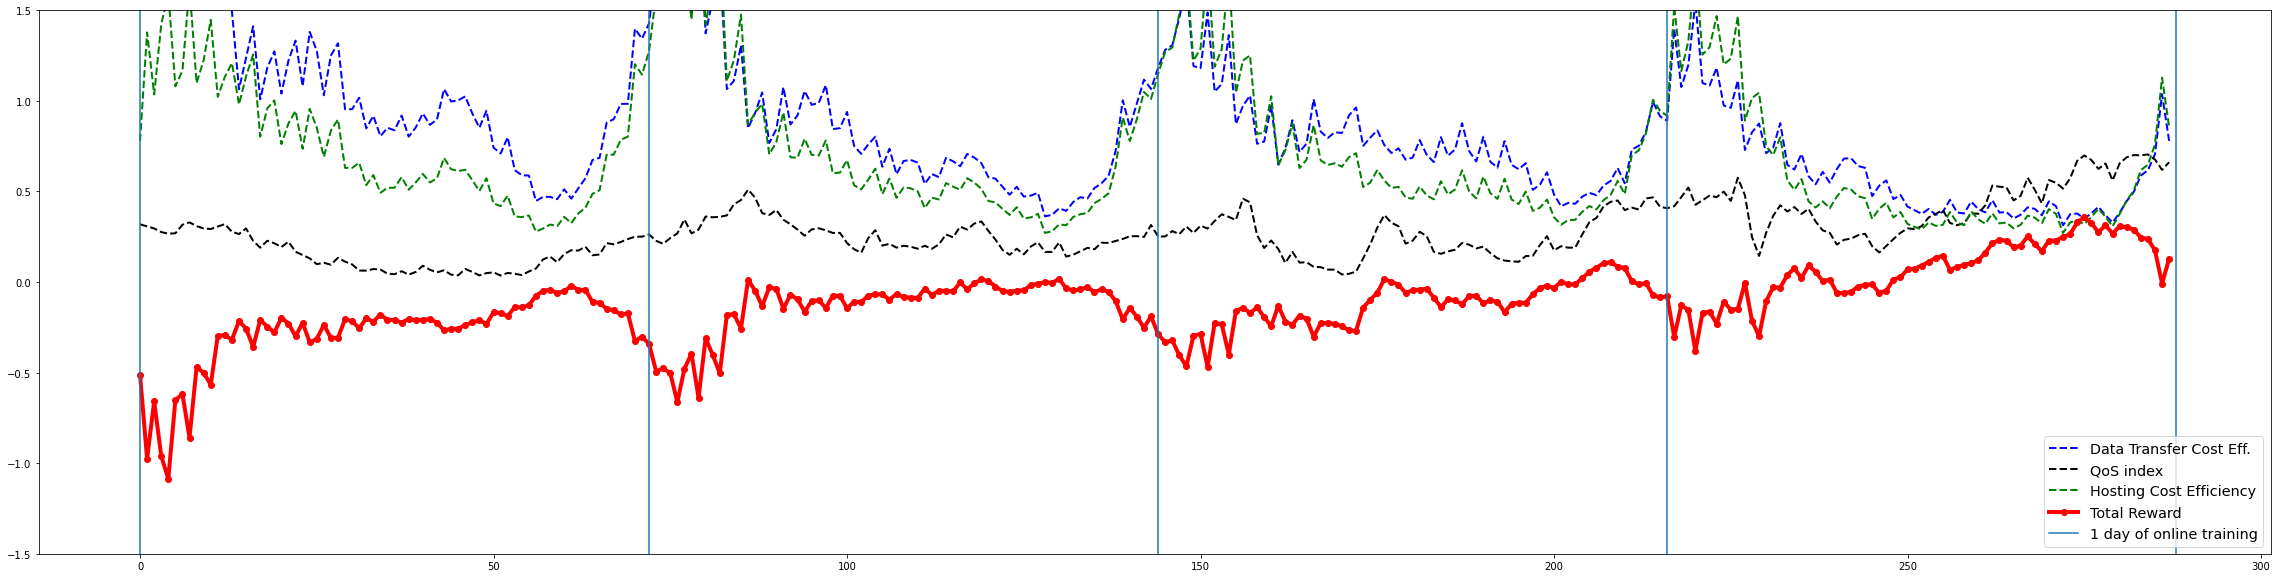

In [ ]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Data
new_sess_stat_tuples = torch.cat([sess_stat_tuple.unsqueeze(0) for sess_stat_tuple in all_sess_stats_tuples], dim=0)
df=pd.DataFrame({'x': range(0,288,), 
                 'Data Transfer Cost Eff.': new_sess_stat_tuples[::,0].numpy() , 
                 'QoS index': new_sess_stat_tuples[::,1].numpy(), 
                 'Hosting Cost Efficiency': new_sess_stat_tuples[::,2].numpy(), 
                 'Total Reward': np.array(all_rewards)[::] })
 
plt.figure(figsize=(40,10))
# multiple line plot
plt.plot( 'x', 'Data Transfer Cost Eff.', data=df, marker='', markerfacecolor='blue', markersize=12, color='blue', linestyle='dashed', linewidth=2)
plt.plot( 'x', 'QoS index', data=df, marker='', color='black',linestyle='dashed', linewidth=2)
plt.plot( 'x', 'Hosting Cost Efficiency', data=df, marker='', color='green',linestyle='dashed', linewidth=2)
plt.plot( 'x', 'Total Reward', data=df, marker='o', color='red', linewidth=4,  label="Total Reward", )
plt.axvline(0, 0, 1)
plt.axvline(72, 0, 1, label='1 day of online training')
plt.axvline(144, 0, 1)
plt.axvline(216, 0, 1)
plt.axvline(288, 0, 1)
plt.ylim(-1.5,1.5)
plt.legend(fontsize='x-large')

In [ ]:
all_sess_stats_tuples = torch.load(modelspath+ '07qos03hce/no_stats_8days_eval_tuples.pt') 
all_rewards = torch.load( modelspath+'07qos03hce/no_stats_8days_eval_rewards.pt') 

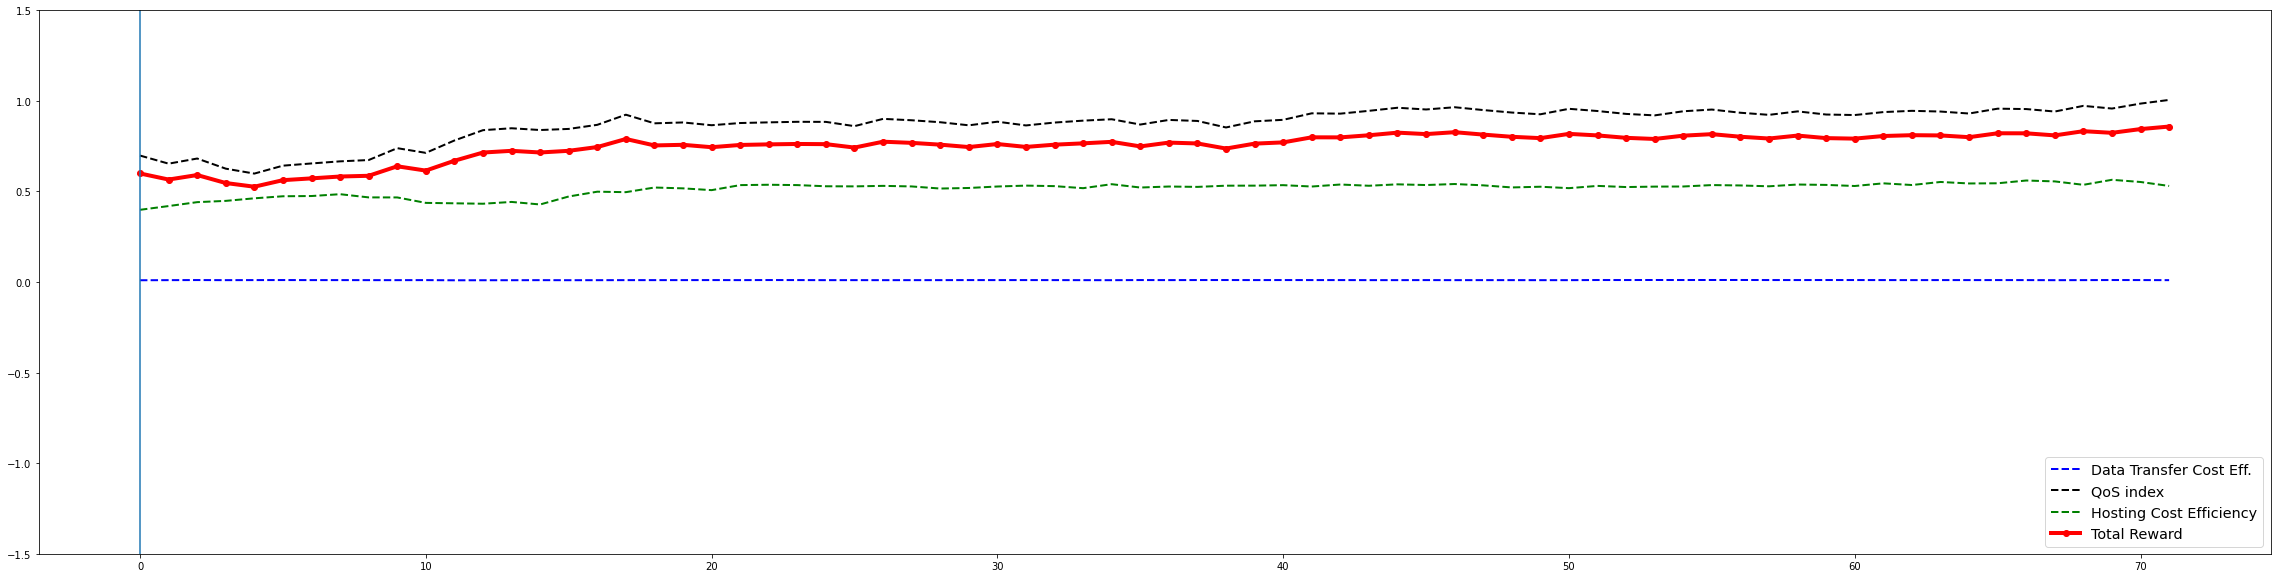

In [ ]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Data
new_sess_stat_tuples = torch.cat([sess_stat_tuple.unsqueeze(0) for sess_stat_tuple in all_sess_stats_tuples], dim=0)
df=pd.DataFrame({'x': range(0,72,), 
                 'Data Transfer Cost Eff.': new_sess_stat_tuples[::,0].numpy() , 
                 'QoS index': new_sess_stat_tuples[::,1].numpy(), 
                 'Hosting Cost Efficiency': new_sess_stat_tuples[::,2].numpy(), 
                 'Total Reward': np.array(all_rewards)[::] })
 
plt.figure(figsize=(40,10))
# multiple line plot
plt.plot( 'x', 'Data Transfer Cost Eff.', data=df, marker='', markerfacecolor='blue', markersize=12, color='blue', linestyle='dashed', linewidth=2)
plt.plot( 'x', 'QoS index', data=df, marker='', color='black',linestyle='dashed', linewidth=2)
plt.plot( 'x', 'Hosting Cost Efficiency', data=df, marker='', color='green',linestyle='dashed', linewidth=2)
plt.plot( 'x', 'Total Reward', data=df, marker='o', color='red', linewidth=4,  label="Total Reward", )
plt.axvline(0, 0, 1)
plt.ylim(-1.5,1.5)
plt.legend(fontsize='x-large')

comparing 2 models

In [ ]:
all_sess_stats_tuples = torch.load(modelspath+ '06qos03hce01dtce/net_stats_tuples_12days.pt') 
all_rewards = torch.load( modelspath+'06qos03hce01dtce/net_stats_rewards_12days.pt') 

all_sess_stats_tuples_2 = torch.load(modelspath+ 'nfvdeep_d3qn_tuples.pt') 
all_rewards_2 = torch.load( modelspath+'nfvdeep_d3qn_rewards.pt') 


new_sess_stats_tuples = torch.cat([sess_stat_tuple.unsqueeze(0) for sess_stat_tuple in all_sess_stats_tuples], dim=0)
new_sess_stats_tuples_2 = torch.cat([sess_stat_tuple.unsqueeze(0) for sess_stat_tuple in all_sess_stats_tuples_2], dim=0)

In [ ]:
len(all_rewards)

288

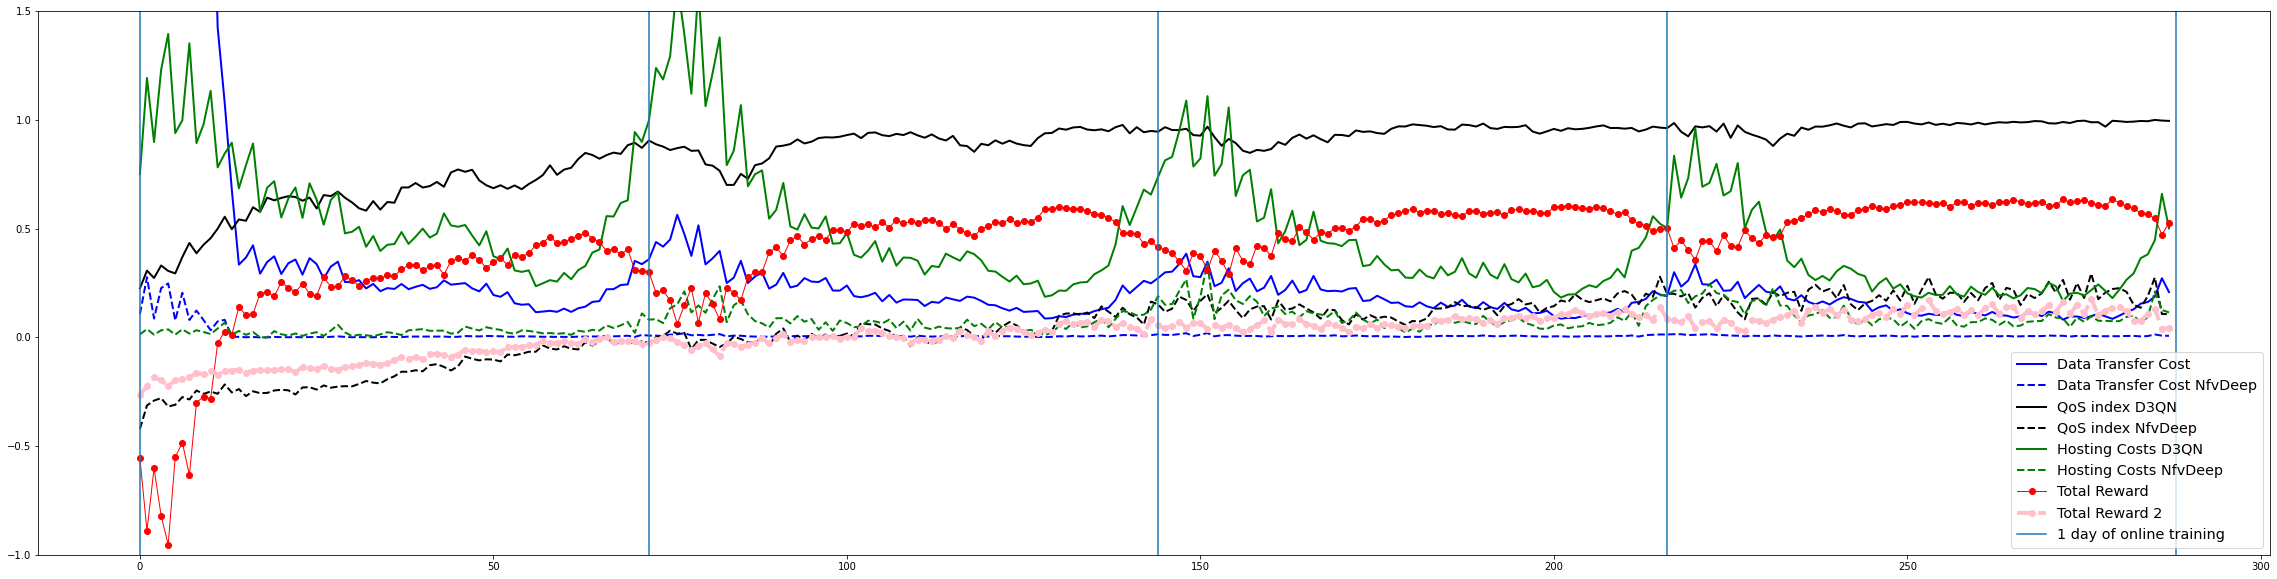

In [ ]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Data
new_sess_stat_tuples = torch.cat([sess_stat_tuple.unsqueeze(0) for sess_stat_tuple in all_sess_stats_tuples], dim=0)

df=pd.DataFrame({'x': range(0,288,1), 
                 'Data Transfer Cost': new_sess_stat_tuples[::1,0].numpy() , 
                 'Data Transfer Cost NfvDeep': new_sess_stats_tuples_2[::1,0].numpy() ,
                 'QoS index D3QN': new_sess_stat_tuples[::1,1].numpy(),  
                 'QoS index NfvDeep': new_sess_stats_tuples_2[::1,1].numpy(),  
                 'Hosting Costs D3QN': new_sess_stat_tuples[::1,2].numpy(), 
                 'Hosting Costs NfvDeep': new_sess_stats_tuples_2[::1,2].numpy(), 
                 'Total Reward D3QN': np.array(all_rewards)[::1],
                 'Total Reward NfvDeep':  np.array(all_rewards_2)[::1]})
 
plt.figure(figsize=(40,10))
# multiple line plot
plt.plot( 'x', 'Data Transfer Cost', data=df, marker='', markerfacecolor='blue', markersize=12, color='blue', linewidth=2)
plt.plot( 'x', 'Data Transfer Cost NfvDeep', data=df, marker='', markerfacecolor='skyblue', markersize=12, color='blue', linestyle='dashed', linewidth=2)

plt.plot( 'x', 'QoS index D3QN', data=df, marker='', color='black', linewidth=2)
plt.plot( 'x', 'QoS index NfvDeep', data=df, marker='', color='black',linestyle='dashed', linewidth=2)

plt.plot( 'x', 'Hosting Costs D3QN', data=df, marker='', color='green', linewidth=2)
plt.plot( 'x', 'Hosting Costs NfvDeep', data=df, marker='', color='green',linestyle='dashed', linewidth=2)

plt.plot( 'x', 'Total Reward D3QN', data=df, marker='o', color='red', linewidth=1,  label="Total Reward", )
plt.plot( 'x', 'Total Reward NfvDeep', data=df, marker='o', color='pink', linewidth=4, linestyle='dashed',  label="Total Reward 2", )

plt.axvline(0, 0, 1)
plt.axvline(72, 0, 1, label='1 day of online training')
plt.axvline(144, 0, 1, )
plt.axvline(216, 0, 1, )
plt.axvline(288, 0, 1, )
plt.ylim(-1,1.5)
plt.legend(fontsize='x-large')


greedy comparation 1 day

In [ ]:
all_sess_stats_tuples = torch.load(modelspath+ 'net_stats_eval_tuples_12days') 
all_rewards = torch.load( modelspath+'10_tpe_eval_rewards.pt') 

greedy_all_sess_stats_tuples = torch.load(modelspath+ '10_tpe_tuples_greedy.pt') 
greedy_all_rewards = torch.load( modelspath+'10_tpe_rewards_greedy.pt') 

new_sess_stats_tuples_greedy = torch.cat([sess_stat_tuple.unsqueeze(0) for sess_stat_tuple in greedy_all_sess_stats_tuples], dim=0)

In [ ]:
len(greedy_all_rewards)

576

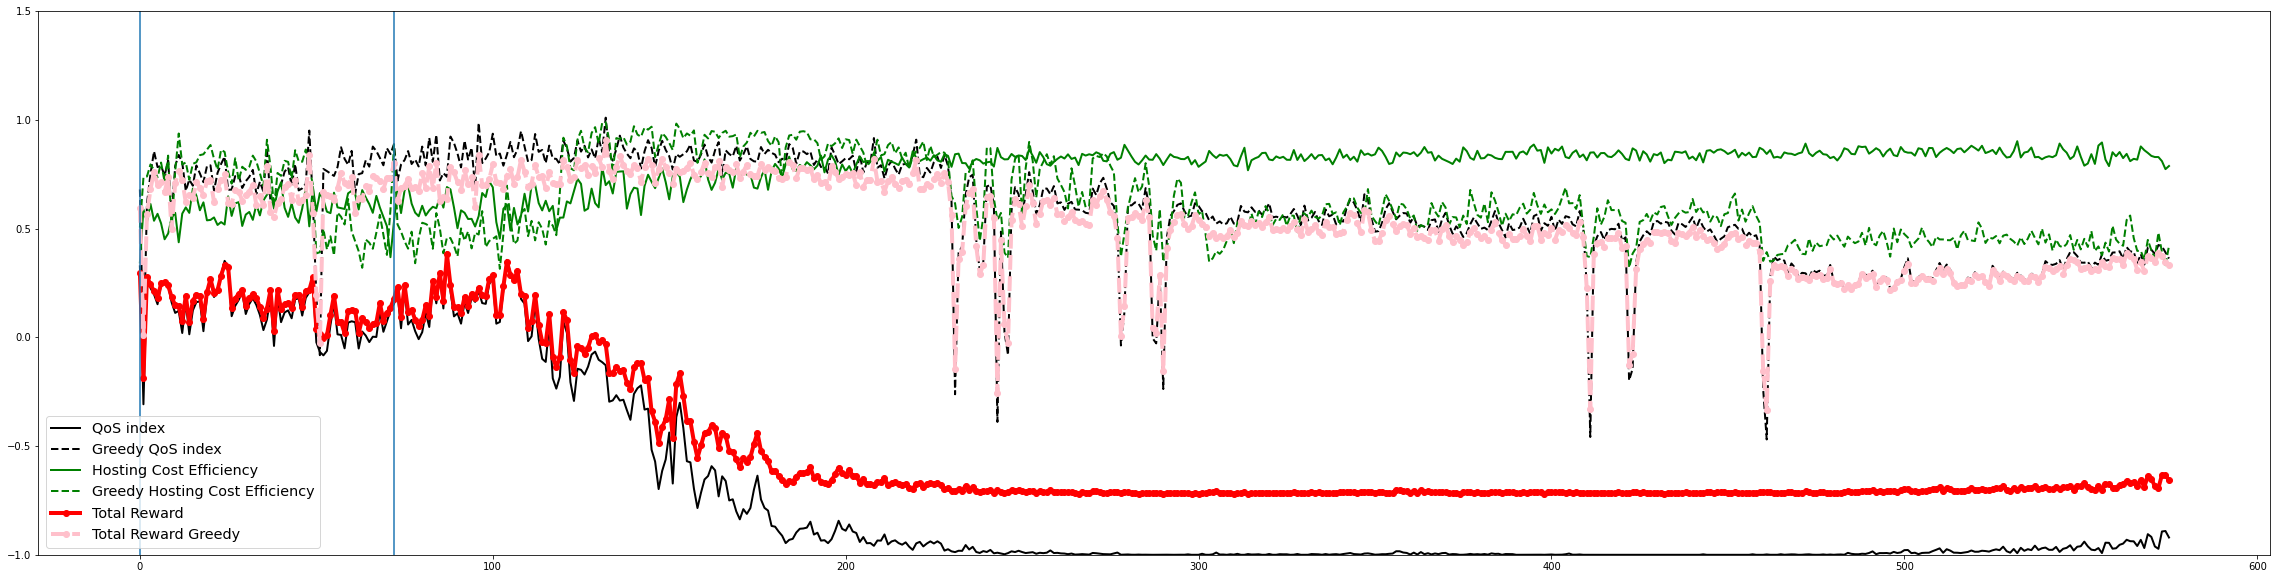

In [ ]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Data
new_sess_stat_tuples = torch.cat([sess_stat_tuple.unsqueeze(0) for sess_stat_tuple in all_sess_stats_tuples], dim=0)

df=pd.DataFrame({'x': range(0,576,1), 
                 'Data Transfer Cost Eff.': new_sess_stat_tuples[::1,0].numpy() , 
                 'Greedy Data Transfer Cost Eff.': new_sess_stats_tuples_greedy[::1,0].numpy() ,
                 'QoS index': new_sess_stat_tuples[::1,1].numpy(),  
                 'Greedy QoS index': new_sess_stats_tuples_greedy[::1,1].numpy(),  
                 'Hosting Cost Efficiency': new_sess_stat_tuples[::1,2].numpy(), 
                 'Greedy Hosting Cost Efficiency': new_sess_stats_tuples_greedy[::1,2].numpy(), 
                 'Total Reward': np.array(all_rewards)[::1],
                 'Total Reward Greedy':  np.array(greedy_all_rewards)[::1]})
 
plt.figure(figsize=(40,10))
# multiple line plot
#plt.plot( 'x', 'Data Transfer Cost Eff.', data=df, marker='', markerfacecolor='blue', markersize=12, color='blue', linewidth=2)
#plt.plot( 'x', 'Greedy Data Transfer Cost Eff.', data=df, marker='', markerfacecolor='skyblue', markersize=12, color='blue', linestyle='dashed', linewidth=2)

plt.plot( 'x', 'QoS index', data=df, marker='', color='black', linewidth=2)
plt.plot( 'x', 'Greedy QoS index', data=df, marker='', color='black',linestyle='dashed', linewidth=2)

plt.plot( 'x', 'Hosting Cost Efficiency', data=df, marker='', color='green', linewidth=2)
plt.plot( 'x', 'Greedy Hosting Cost Efficiency', data=df, marker='', color='green',linestyle='dashed', linewidth=2)

plt.plot( 'x', 'Total Reward', data=df, marker='o', color='red', linewidth=4,  label="Total Reward", )
plt.plot( 'x', 'Total Reward Greedy', data=df, marker='o', color='pink', linewidth=4, linestyle='dashed',  label="Total Reward Greedy", )

plt.axvline(0, 0, 1)
plt.axvline(72, 0, 1, label='')
plt.ylim(-1,1.5)
plt.legend(fontsize='x-large')


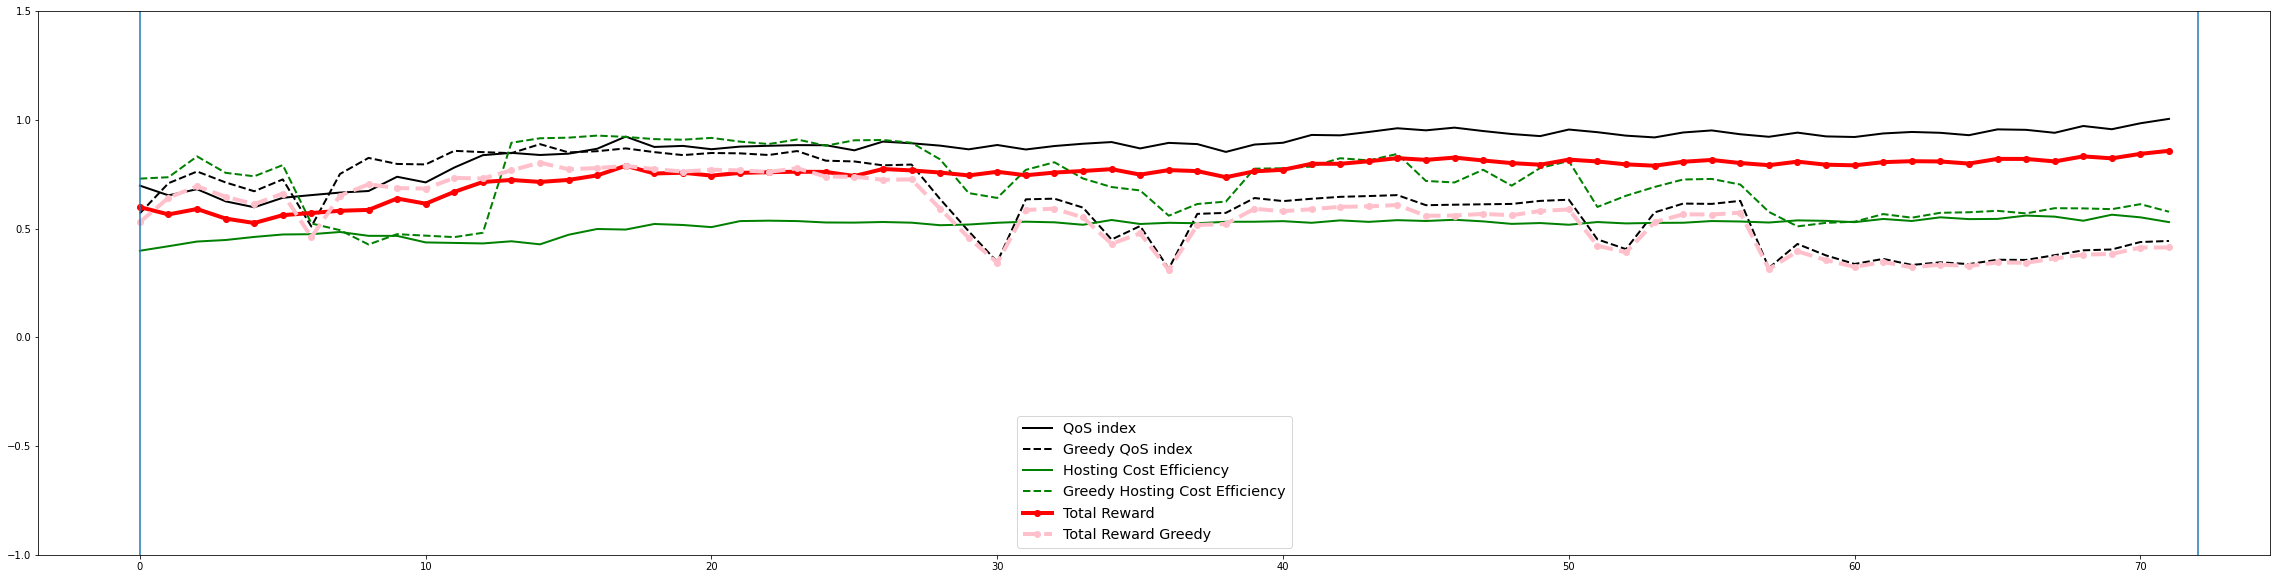

In [ ]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Data
new_sess_stat_tuples = torch.cat([sess_stat_tuple.unsqueeze(0) for sess_stat_tuple in all_sess_stats_tuples], dim=0)

df=pd.DataFrame({'x': range(0,72,1), 
                 'Data Transfer Cost Eff.': new_sess_stat_tuples[-72::1,0].numpy() , 
                 'Greedy Data Transfer Cost Eff.': new_sess_stats_tuples_greedy[-72::1,0].numpy() ,
                 'QoS index': new_sess_stat_tuples[-72::1,1].numpy(),  
                 'Greedy QoS index': new_sess_stats_tuples_greedy[-72::1,1].numpy(),  
                 'Hosting Cost Efficiency': new_sess_stat_tuples[-72::1,2].numpy(), 
                 'Greedy Hosting Cost Efficiency': new_sess_stats_tuples_greedy[-72::1,2].numpy(), 
                 'Total Reward': np.array(all_rewards)[-72::1],
                 'Total Reward Greedy':  np.array(greedy_all_rewards)[::1]})
 
plt.figure(figsize=(40,10))
# multiple line plot
#plt.plot( 'x', 'Data Transfer Cost Eff.', data=df, marker='', markerfacecolor='blue', markersize=12, color='blue', linewidth=2)
#plt.plot( 'x', 'Greedy Data Transfer Cost Eff.', data=df, marker='', markerfacecolor='skyblue', markersize=12, color='blue', linestyle='dashed', linewidth=2)

plt.plot( 'x', 'QoS index', data=df, marker='', color='black', linewidth=2)
plt.plot( 'x', 'Greedy QoS index', data=df, marker='', color='black',linestyle='dashed', linewidth=2)

plt.plot( 'x', 'Hosting Cost Efficiency', data=df, marker='', color='green', linewidth=2)
plt.plot( 'x', 'Greedy Hosting Cost Efficiency', data=df, marker='', color='green',linestyle='dashed', linewidth=2)

plt.plot( 'x', 'Total Reward', data=df, marker='o', color='red', linewidth=4,  label="Total Reward", )
plt.plot( 'x', 'Total Reward Greedy', data=df, marker='o', color='pink', linewidth=4, linestyle='dashed',  label="Total Reward Greedy", )

plt.axvline(0, 0, 1)
plt.axvline(72, 0, 1, label='')
plt.ylim(-1,1.5)
plt.legend(fontsize='x-large')




concatenation


In [ ]:
all_sess_stats_tuples = torch.load(modelspath+ '40_tpe_tuples.pt') 
all_rewards = torch.load( modelspath+'40_tpe_rewards.pt') 

In [ ]:
all_sess_stats_tuples2 = torch.load(modelspath+ '40_tpe_tuples_4days.pt') 
all_rewards2= torch.load( modelspath+'40_tpe_rewards_4days.pt') 

In [ ]:
all_sess_stats_tuples = all_sess_stats_tuples + all_sess_stats_tuples2

In [ ]:
all_rewards = torch.cat((all_rewards,all_rewards2))

In [ ]:
len(all_sess_stats_tuples)

576

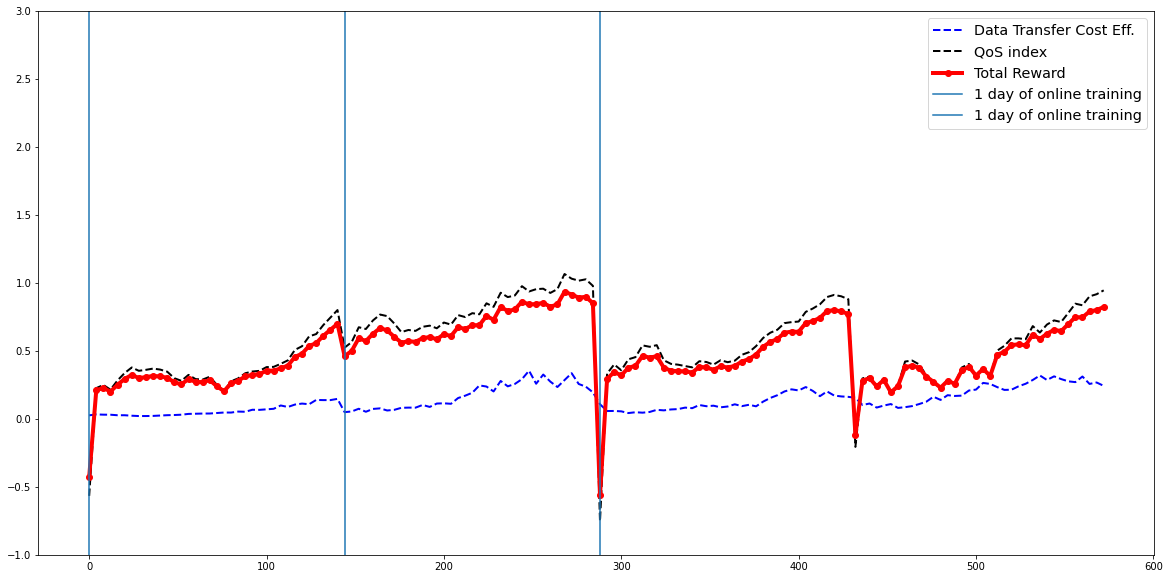

In [ ]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Data
new_sess_stat_tuples = torch.cat([sess_stat_tuple.unsqueeze(0) for sess_stat_tuple in all_sess_stats_tuples], dim=0)
df=pd.DataFrame({'x': range(0,576,4), 'Data Transfer Cost Eff.': new_sess_stat_tuples[::4,0].numpy() , 'QoS index': new_sess_stat_tuples[::4,1].numpy(), 'Total Reward': np.array(all_rewards)[::4] })
 
plt.figure(figsize=(20,10))
# multiple line plot
plt.plot( 'x', 'Data Transfer Cost Eff.', data=df, marker='', markerfacecolor='blue', markersize=12, color='blue', linestyle='dashed', linewidth=2)
plt.plot( 'x', 'QoS index', data=df, marker='', color='black',linestyle='dashed', linewidth=2)
plt.plot( 'x', 'Total Reward', data=df, marker='o', color='red', linewidth=4,  label="Total Reward", )
plt.axvline(0, 0, 1)
plt.axvline(144, 0, 1, label='1 day of online training')

plt.axvline(288, 0, 1, label='1 day of online training')
plt.ylim(-1,3)
plt.legend(fontsize='x-large')


In [ ]:
pd.Series(all_rewards[-1440:].numpy()).describe()

count    1440.000000
mean       -0.649092
std         0.074415
min        -0.784060
25%        -0.697098
50%        -0.659761
75%        -0.613889
max        -0.184030
dtype: float64

In [ ]:
pd.Series(all_rewards[1440:-2880].numpy()).describe()

count    1440.000000
mean       -0.631701
std         0.111539
min        -0.773782
25%        -0.701688
50%        -0.674083
75%        -0.600496
max        -0.027675
dtype: float64

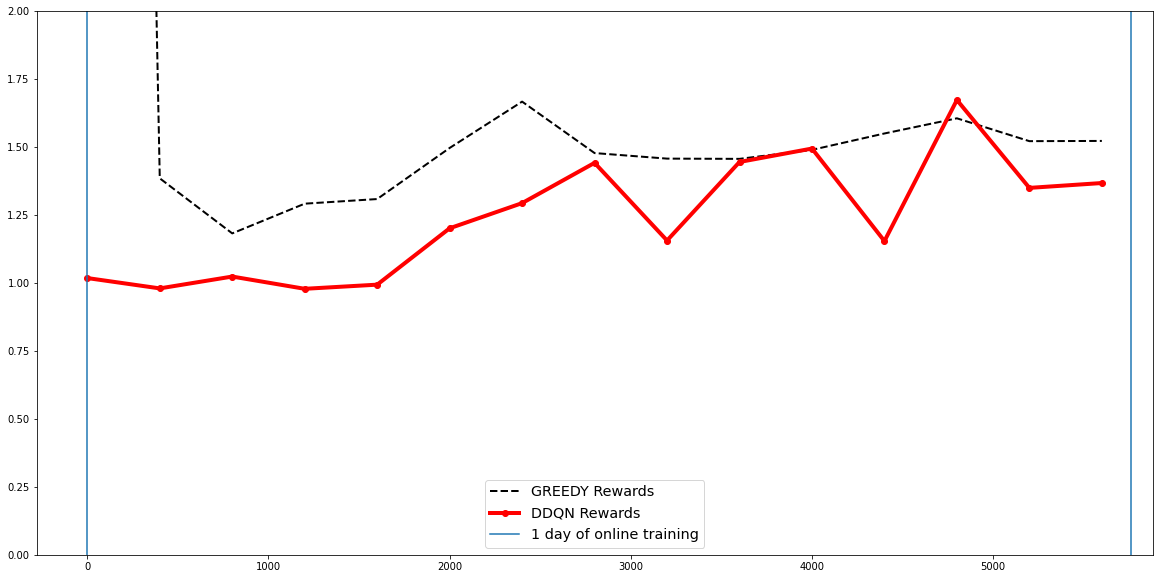

In [ ]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Data
new_sess_stat_tuples = torch.cat([sess_stat_tuple.unsqueeze(0) for sess_stat_tuple in all_sess_stats_tuples], dim=0)
df=pd.DataFrame({'x': range(0,5760,400), 'DDQN Rewards': np.array(all_rewards)[28800:34560:400] ,  'GREEDY Rewards': np.array(greedy_rewards)[::400] })
 
plt.figure(figsize=(20,10))
# multiple line plot
plt.plot( 'x', 'GREEDY Rewards', data=df, marker='', color='black',linestyle='dashed', linewidth=2, label='GREEDY Rewards')
plt.plot( 'x', 'DDQN Rewards', data=df, marker='o', color='red', linewidth=4,  label="DDQN Rewards", )
plt.axvline(0, 0, 1)
plt.axvline(5760, 0, 1, label='1 day of online training')
plt.ylim(0,2)
plt.legend(fontsize='x-large')


concatenation


In [ ]:
all_sess_stats_tuples = torch.load(modelspath+ 'tuples.pt') 
all_rewards = torch.load( modelspath+'rewards.pt') 

#### DDPG: 

In [ ]:
class ExperienceReplaySimple(object):

    def __init__(self, capacity):

        self.capacity = capacity

        self.memory = []

        self.position = 0

    def push(self, net_state_tensor,  ingestion_state_tensor, request_tensor, action, new_net_state_tensor,
              new_ingestion_state_tensor, new_request_tensor, reward, done_signal):

        transition = (net_state_tensor,  ingestion_state_tensor, request_tensor, action, new_net_state_tensor,
                       new_ingestion_state_tensor, new_request_tensor, reward, done_signal)

        if self.position >= len(self.memory):

            self.memory.append(transition)

        else:

            self.memory[self.position] = transition

        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):

        return zip(*random.sample(self.memory, batch_size))

    def __len__(self):

        return len(self.memory)


class Critic(nn.Module):


    def __init__(self, req_tensor_dim, hidden_size, output_size, num_of_hosting_nodes=16):

        super(Critic, self).__init__()

        self.input_size = (num_of_hosting_nodes * 4) + req_tensor_dim

        self.linear1 = nn.Linear(self.input_size, hidden_size)

        self.linear2 = nn.Linear(hidden_size, hidden_size)

        self.linear3 = nn.Linear(hidden_size, output_size)


    def forward(self, curr_net_state_tensor, ingestion_state_tensor, request_tensor, action_tensor):
        """
        Params state and actions are torch tensors
        """
        input = torch.cat([curr_net_state_tensor,
                           ingestion_state_tensor,
                           request_tensor,
                           action_tensor], dim=2).view(-1, 1, self.input_size)

        x = torch.relu(self.linear1(input))

        x = torch.relu(self.linear2(x))

        x = self.linear3(x)

        return x


class Actor(nn.Module):

    def __init__(self, req_tensor_dim, hidden_size, output_size, num_of_hosting_nodes=16):

        super(Actor, self).__init__()

        self.input_size = (num_of_hosting_nodes * 3) + req_tensor_dim

        self.linear1 = nn.Linear(self.input_size, hidden_size)

        self.linear2 = nn.Linear(hidden_size, hidden_size)

        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self,  curr_net_state_tensor, ingestion_state_tensor, request_tensor):
        """
        Param state is a torch tensor
        """
        state = torch.cat([curr_net_state_tensor,
                           ingestion_state_tensor,
                           request_tensor], dim=2).view(-1, 1, self.input_size)

        x = torch.relu(self.linear1(state))

        x = torch.relu(self.linear2(x))

        x = torch.tanh(self.linear3(x))

        return x

class OUNoise(object):

    def __init__(self, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.0, decay_period=100000):

        self.mu = mu

        self.theta = theta

        self.sigma = max_sigma

        self.max_sigma = max_sigma

        self.min_sigma = min_sigma

        self.decay_period = decay_period

        self.action_dim = N_h

        self.low = 0

        self.high = 1

        self.reset()


    def reset(self):

        self.state = (torch.ones(self.action_dim) * self.mu).to(device)


    def evolve_state(self):

        x = self.state

        dx = self.theta * (self.mu - x) + self.sigma * torch.randn(self.action_dim).to(device)

        self.state = x + dx

        return self.state


    def get_action(self, action, t=0):

        ou_state = self.evolve_state()

        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)

        return (action + ou_state).clamp(self.low, self.high)


class DDPGAgent(object):


    def __init__(self, simulator, N_h=16,
                 actor_learning_rate=0.00025,
                 critic_learning_rate=0.0025,
                 actor_model_name='DDPG_Actor',
                 critic_model_name='DDPG_Critic',
                 resume_previous_training=False,
                 replay_mem_size=10000,
                 batch_size= 64,
                 tau=0.01,
                 gamma=0.99,
                 save_model_frequency=10000,
                 hidden_linear_dim=2048):


        self.gamma = gamma

        self.tau = tau

        self.N_h = N_h

        self.actor = Actor(50, hidden_linear_dim, N_h).to(device)

        self.actor_target = Actor(50, hidden_linear_dim, N_h).to(device)

        self.critic = Critic(50, hidden_linear_dim, N_h).to(device)

        self.critic_target = Critic(50, hidden_linear_dim, N_h).to(device)

        self.simulator = simulator

        self.memory_sample_batch_size = batch_size

        self.save_model_frequency = save_model_frequency

        self.actor_model_name = actor_model_name

        self.critic_model_name = critic_model_name


        if resume_previous_training and os.path.exists(file2save):

            print("Loading previously saved model ... ")

            self.actor.load_state_dict(load_model(file2save))



        # We initialize the target networks as copies of the original networks
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):

            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):

            target_param.data.copy_(param.data)


        # Training
        self.memory = ExperienceReplaySimple(replay_mem_size)

        self.critic_criterion = nn.MSELoss()

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_learning_rate)

        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_learning_rate)


    def get_action_tensor(self, curr_net_state_tensor, ingestion_state_tensor, request_tensor):

        with torch.no_grad():

            action_from_nn = self.actor(curr_net_state_tensor, ingestion_state_tensor, request_tensor)

        return action_from_nn

    def get_decoded_action(self, action_tensor):

        action = torch.max(action_tensor, 2)[1]

        action = action.item()

        return action

    def get_binary_action(self, action_tensor_batch):

        batch_dim = action_tensor_batch.shape[0]

        actions = [self.get_decoded_action(action_tensor.unsqueeze(0)) for action_tensor in action_tensor_batch]

        binary_action_tensor = torch.zeros((batch_dim,1,self.N_h))

        for idx, action in enumerate(actions):

            binary_action_tensor[idx][0][action] = 1

        return binary_action_tensor

    def update(self):

        if (len(self.memory) < self.memory_sample_batch_size):
            return

        net_states_sampled, ingestion_states, request_tensors, action_tensors, new_net_states_sampled, \
        new_ingestion_states, new_request_tensors, rewards, _ = self.memory.sample(self.memory_sample_batch_size)

        net_states = torch.cat([net_state for net_state in net_states_sampled]).to(device)

        new_net_states = torch.cat([net_state for net_state in new_net_states_sampled]).to(device)

        ing_states = torch.cat([ing_s for ing_s in ingestion_states]).to(device)

        new_ing_states = torch.cat([new_ing_s for new_ing_s in new_ingestion_states]).to(device)

        req_tensors = torch.cat([req_tens for req_tens in request_tensors]).to(device)

        new_req_tensors = torch.cat([req_tens for req_tens in new_request_tensors]).to(device)

        rewards = torch.Tensor(rewards).view(-1,1,1).to(device)

        action_tensors = torch.cat([action_tensor for action_tensor in action_tensors]).to(device)

        binary_action_tensors = self.get_binary_action(action_tensors).to(device)

        # Critic loss
        Qvals = self.critic(net_states, ing_states, req_tensors, binary_action_tensors)

        next_actions = self.actor_target(new_net_states, new_ing_states, new_req_tensors)

        next_Q = self.critic_target(new_net_states, new_ing_states, new_req_tensors, next_actions.detach())

        Qprime = rewards + self.gamma * next_Q

        critic_loss = self.critic_criterion(Qvals, Qprime)

        # Actor loss
        policy_loss = -self.critic(net_states,
                                   ing_states,
                                   req_tensors,
                                   self.get_binary_action(self.actor(net_states,
                                                ing_states,
                                                req_tensors)).to(device)
                                   ).mean()

        # update networks
        self.actor_optimizer.zero_grad()

        policy_loss.backward()

        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()

        critic_loss.backward()

        self.critic_optimizer.step()

        # update target networks
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):

            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):

            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))


def training_DDPG():

    noise = OUNoise(mu=mu,
                    theta=theta,
                    max_sigma=max_sigma,
                    min_sigma=min_sigma,
                    decay_period=decay_period)

    with open( modelspath + "/init_values_for_training/init_for_training_sim.txt", "rb") as fp:  # Pickling

      simulator = pickle.load(fp)

    net_state, reqs_to_process = simulator.ns, simulator.incoming_reqs

    prev_action = simulator.prev_action

    agent = DDPGAgent(simulator=simulator,
                      actor_learning_rate=actor_learning_rate,
                      critic_learning_rate=critic_learning_rate,
                      gamma=gamma,
                      resume_previous_training=resume_previous_training,
                      actor_model_name=actor_model_name,
                      critic_model_name=critic_model_name,
                      batch_size=memory_sample_batch_size,
                      replay_mem_size=replay_mem_size,
                      tau=tau,
                      save_model_frequency=save_model_frequency,
                      hidden_linear_dim=hidden_layer)

    start_time = time.time()

    all_rewards = []

    all_sess_stats_tuples = []

    all_net_stat_tuples = []

    absolute_steps = 0

    prev_action = None

    for i_episode in tqdmsito(range(num_episodes)):

        rewards = []

        sess_stats_tuples = []

        if simulator.timesteps >= 28800:

            print('\nresetting simulator\n')

            with open( modelspath + "/init_values_for_training/init_for_training_sim.txt", "rb") as fp:  # Pickling

              simulator = pickle.load(fp)

            net_state, reqs_to_process = simulator.ns, simulator.incoming_reqs

            prev_action = simulator.prev_action

        done_signal = False

        curr_net_state_tensor = None

        while not done_signal:

            absolute_steps += 1

            if curr_net_state_tensor == None:

                curr_net_state_tensor, ingestion_state_tensor, request_tensor = preprocess_state(net_state, reqs_to_process, simulator)

            proto_action_tensor = agent.get_action_tensor(curr_net_state_tensor.to(device),
                                             ingestion_state_tensor.to(device),
                                             request_tensor)

            action_tensor = noise.get_action(proto_action_tensor, absolute_steps)

            action = agent.get_decoded_action(action_tensor)

            prev_action = action

            net_state, reqs_to_process, assignation_reward, sess_stats_tuple = simulator.assignation_step(action)

            if absolute_steps % 4 == 0:

                sess_stats_tuples.append(sess_stats_tuple)

                rewards.append(assignation_reward)

            while len(reqs_to_process) == 0:
                # We just ended the new requests of this timestep,
                # so we take an adaptation action
                # and receive the new requests

                if simulator.timesteps % adaptation_pace_timesteps == 0:

                    net_state, reqs_to_process, net_stat_tuple = simulator.take_greedy_adaptation_action()

                else:

                    net_stat_tuple = simulator.next_step()

                    net_state, reqs_to_process = simulator.ns, simulator.incoming_reqs

                all_net_stat_tuples.append(net_stat_tuple)

                if simulator.timesteps % timesteps_per_episode == 0:

                    done_signal = True

            new_net_state_tensor, new_ingestion_tensor, new_request_tensor = preprocess_state(net_state, reqs_to_process, simulator)

            agent.memory.push(curr_net_state_tensor.to('cpu'),
                              ingestion_state_tensor.to('cpu'),
                              request_tensor.to('cpu'),
                              action_tensor.to('cpu'),
                              new_net_state_tensor,
                              new_ingestion_tensor,
                              new_request_tensor,
                              assignation_reward,
                              done_signal)

            agent.update()

            curr_net_state_tensor, ingestion_state_tensor, request_tensor = \
                new_net_state_tensor, new_ingestion_tensor, new_request_tensor

        mean_sess_stats = torch.mean(
            torch.cat(([torch.Tensor(sess_stats_tuple) for sess_stats_tuple in sess_stats_tuples])).view(-1, 3), dim=0)

        mean_reward = torch.mean(torch.Tensor(rewards)).item()

        all_rewards.append(mean_reward)

        all_sess_stats_tuples.append(mean_sess_stats)

        if (i_episode % report_interval == 0):

            print('Episode ', i_episode, 'Simulator timesteps', simulator.timesteps, ' absolute assig. steps ', absolute_steps)

            print("Average reward:", mean_reward)

            print('dt_cost_eff', mean_sess_stats[0])

            print('sess_QoS', mean_sess_stats[1])

            print('hosting_cost_eff', mean_sess_stats[2])

            print('Mean residual core bw', torch.mean(simulator.residual_cB))

            print('Mean residual mesh bw', torch.mean(simulator.residual_mB))

            print('Mean residual edge bw', torch.mean(simulator.residual_eB), '\n')

    elapsed_time = time.time() - start_time

    print("Elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


In [ ]:
from tqdm.notebook import tqdm as tqdmsito


N_h = 16

N_cp = 41

N_uc = 4

replay_mem_size = 10000

num_episodes = 288

random.seed(777)

report_interval = 200

gamma = 0.99

actor_learning_rate = 1e-4

critic_learning_rate = 1e-4

resume_previous_training = False

save_model_frequency = 500

hidden_layer = 256

memory_sample_batch_size = 32

actor_model_name = 'dummy_actor_model'

critic_model_name = 'dummy_critic_model'

adaptation_pace_timesteps = 20

timesteps_per_episode = 80

tau = 1e-3

mu=0.0

theta=0.15

max_sigma=0.6

min_sigma=0.0

decay_period=100000

assigner_score_weigths = {'dt_cost_eff': 0.1,
                            'qos': 0.6,
                            'hosting_cost_efficiency': 0.3}


max_vnf_capacity = 20

all_sess_stats_tuples, all_rewards, critic, actor = training_DDPG()

Episode  0 Simulator timesteps 160  absolute assig. steps  3832
Average reward: 0.12317979335784912
dt_cost_eff tensor(0.0521)
sess_QoS tensor(0.0731)
hosting_cost_eff tensor(0.2228)
Mean residual core bw tensor(19.7439)
Mean residual mesh bw tensor(40.8432)
Mean residual edge bw tensor(29.6048) 

Episode  200 Simulator timesteps 16160  absolute assig. steps  1230508
Average reward: 0.18888290226459503
dt_cost_eff tensor(0.5629)
sess_QoS tensor(0.0030)
hosting_cost_eff tensor(0.4350)
Mean residual core bw tensor(19.8201)
Mean residual mesh bw tensor(42.9159)
Mean residual edge bw tensor(21.9385) 


Elapsed time:  04:49:07


TypeError: ignored

In [ ]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Data
new_sess_stat_tuples = torch.cat([sess_stat_tuple.unsqueeze(0) for sess_stat_tuple in all_sess_stats_tuples], dim=0)
df=pd.DataFrame({'x': range(0,288,1), 
                 'Data Transfer Cost Eff.': new_sess_stat_tuples[::1,0].numpy() , 
                 'QoS index': new_sess_stat_tuples[::1,1].numpy(), 
                 'Hosting Cost Efficiency': new_sess_stat_tuples[::1,2].numpy(), 
                 'Total Reward': np.array(all_rewards)[::1] })
 
plt.figure(figsize=(40,10))
# multiple line plot
plt.plot( 'x', 'Data Transfer Cost Eff.', data=df, marker='', markerfacecolor='blue', markersize=12, color='blue', linestyle='dashed', linewidth=2)
plt.plot( 'x', 'QoS index', data=df, marker='', color='black',linestyle='dashed', linewidth=2)
plt.plot( 'x', 'Hosting Cost Efficiency', data=df, marker='', color='green',linestyle='dashed', linewidth=2)
plt.plot( 'x', 'Total Reward', data=df, marker='o', color='red', linewidth=4,  label="Total Reward", )
plt.axvline(0, 0, 1)
#plt.axvline(230, 0, 1, label='1 day of online training')
#plt.axvline(1152, 0, 1)
#plt.axvline(1728, 0, 1)
#plt.axvline(2304, 0, 1)
plt.ylim(-1.5,1.5)
plt.legend(fontsize='x-large')

NameError: ignored